In [14]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import statistics
import pandas as pd
import numpy as np
import warnings
import statsmodels.api as sm

warnings.filterwarnings("ignore")

In [ ]:
#diag_usage_df = pd.read_excel('../Data/DiagUsage_Cleaned.xlsx', sheet_name='connect_system')

diag_usage_df.sample(5)

In [16]:
#double check that data has been cleaned
num_duplicated = diag_usage_df.duplicated().sum()
print(num_duplicated)

0


In [17]:
diag_usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171997 entries, 0 to 171996
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   timestamp        171997 non-null  datetime64[ns]
 1   siteId           171997 non-null  int64         
 2   OsName           171997 non-null  object        
 3   client_OS        171997 non-null  object        
 4   vin              171997 non-null  object        
 5   year             171997 non-null  int64         
 6   make             171997 non-null  object        
 7   model            171997 non-null  object        
 8   system           171997 non-null  object        
 9   veh_desc         171997 non-null  object        
 10  vci_version      171997 non-null  object        
 11  scan_method      171997 non-null  object        
 12  batt_voltage     171997 non-null  float64       
 13  result_string    171997 non-null  object        
 14  result           171

In [18]:
diag_usage_df.head(5)

,timestamp,siteId,OsName,client_OS,vin,year,make,model,system,veh_desc,vci_version,scan_method,batt_voltage,result_string,result,state,city,product_type,postal_code,system_category
0,2024-12-30 19:36:51.987,787856,Android,Android 14,1FTER1EH6PL,2023,Ford,Ranger,Enhanced Powertrain CAN,2023 Ford Ranger,22.3.2439.2,quick_scan,14.39,Failed to connect to system,0,OH,Steubenville,COLLISION,43952-1421,Enhanced Powertrain
1,2024-12-30 19:36:55.560,369610,Android,Android 10,JF2SJADC2FH,2015,Subaru,Forester,Enhanced Powertrain CAN,2015 Subaru Forester,22.1.2418.1,quick_scan,14.30,Successfully connected,1,CA,YUCCA VALLEY,REPAIR,92284-2633,Enhanced Powertrain
2,2024-12-30 19:37:28.692,143234,Android,Android 14,1HGCM56177A,2007,Honda,Accord,Enhanced Powertrain,2007 Honda Accord,21.2.2323.1,quick_scan,11.05,Successfully connected,1,TN,WHITE BLUFF,REPAIR,37187,Enhanced Powertrain
3,2024-12-30 19:37:28.298,503311,Android,Android 14,1FTEW1E59LF,2020,Ford,F150,Enhanced Powertrain CAN,2020 Ford F150,22.3.2439.2,quick_scan,11.78,Successfully connected,1,unknown,unknown,unknown,unknown,Enhanced Powertrain
4,2024-12-30 19:44:32.861,744654,Android,Android 14,3C4PDDEG8JT,2018,Dodge,Journey,Enhanced Powertrain,2018 Dodge Journey,21.3.2337.1,manual scan,0.00,Successfully connected,1,IN,MARION,COLLISION,46952-2535,Enhanced Powertrain


### Investigate connection success rates by VCI version
The VCI (Vehicle Communications Interface) is the hardware device that communicates with the vehicle. The ALLDATA mobile application communicates with the VCI via bluetooth. 

In [19]:
#assumes passed in df has a column named 'result' with values 0 or 1
def create_correlation_table(source_df, feature):
    df = pd.crosstab(source_df[feature], source_df['result'])
    df['total'] = df[0] + df[1]
    overall_total = df['total'].sum()
    df['cumulative%'] = (df['total'] / overall_total) * 100
    df['success%'] = (df[1] / df['total']) * 100
    return df

In [20]:
vci_version_df = pd.crosstab(diag_usage_df['vci_version'], diag_usage_df['result'])
vci_version_df['total'] = vci_version_df[0] + vci_version_df[1]
overall_total = vci_version_df['total'].sum()
vci_version_df['percentage'] = (vci_version_df['total'] / overall_total) * 100
vci_version_df['success_rate'] = (vci_version_df[1] / vci_version_df['total']) * 100
vci_version_df['failure_rate'] = 100 - vci_version_df['success_rate']
# Sort by percentage in descending order
vci_version_df = vci_version_df.sort_values(by='percentage', ascending=False)
# Add a cumulative percentage column
vci_version_df['cumulative_percentage'] = vci_version_df['percentage'].cumsum()
# Display the first few rows
vci_version_df

result,0,1,total,percentage,success_rate,failure_rate,cumulative_percentage
vci_version,,,,,,,
22.3.2439.2,10049,73322,83371,48.472357,87.946648,12.053352,48.472357
22.1.2418.1,5490,41518,47008,27.330709,88.321137,11.678863,75.803066
22.1.2411.1,919,8784,9703,5.641377,90.528702,9.471298,81.444444
21.3.2337.1,1133,8013,9146,5.317535,87.612071,12.387929,86.761978
21.2.2323.1,659,6394,7053,4.100653,90.656458,9.343542,90.862631
21.0.2307.1,654,5552,6206,3.608202,89.461811,10.538189,94.470834
22.2.2424.1,464,3748,4212,2.448880,88.983856,11.016144,96.919714
20.3.2237.1,188,1660,1848,1.074437,89.826840,10.173160,97.994151
20.0.2150.1,111,836,947,0.550591,88.278775,11.721225,98.544742


In [ ]:
#Too many older VCI software version are still being used by customers! A recommendation is to force customers to upgrade to the latest version of the software. 
# The top 7 versions account for almost 97% percent of connetions. Others will be dropped to prevent issues that may have already been resolved from affecting the model.
#only keep top 7 versions in diag_usage_df
top_versions = vci_version_df.head(7).index.tolist()
#vci_version_df = vci_version_df.head(7)
diag_usage_df = diag_usage_df[diag_usage_df['vci_version'].isin(top_versions)]

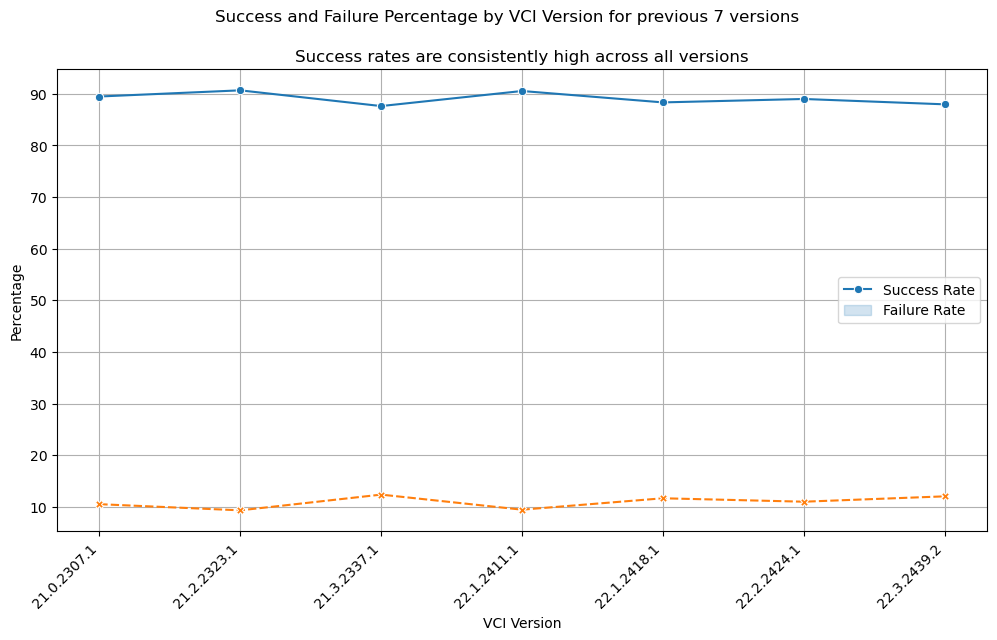

In [120]:
#create line plot of vci connection success rate based on vci version
vci_version_df2 = vci_version_df[['success_rate', 'failure_rate']]
vci_version_df2.sort_index(inplace=True)

#Plotting success and failure rate by VCI version
plt.figure(figsize=(12, 6))
sns.lineplot(data=vci_version_df2, markers=True)

# Formatting the plot
plt.xticks(rotation=45, ha="right")
plt.xlabel("VCI Version")
plt.ylabel("Percentage")
plt.suptitle("Success and Failure Percentage by VCI Version for previous 7 versions")
plt.title("Success rates are consistently high across all versions")
plt.legend(labels=["Success Rate", "Failure Rate"])
plt.grid(True)

In [124]:
#remove years before 2000
diag_usage_df = diag_usage_df[diag_usage_df['year'] > 1999]

In [125]:
#write cleaned data to excel for model building
diag_usage_df.to_excel('../Data/DiagUsage_Full.xlsx', sheet_name='connect_system', index=False)

## Univariate Analysis of vehicle parameters

In [122]:
diag_usage_df.nunique()

timestamp          165215
siteId               1695
OsName                  4
client_OS              72
vin                 61808
year                   26
make                   46
model                 594
system                866
veh_desc             4908
vci_version             7
scan_method             2
batt_voltage          446
result_string           7
result                  2
state                  65
city                 1196
product_type            3
postal_code          1578
system_category        26
make_category           4
dtype: int64

In [123]:
diag_usage_df.describe().round(2).T

,count,mean,min,25%,50%,75%,max,std
timestamp,165218,2024-12-05 18:30:39.981455360,2024-10-01 20:24:02.463000,2024-11-01 19:31:28.568249856,2024-12-04 17:33:20.955000064,2025-01-09 20:34:05.216999936,2025-02-09 16:28:29.957000,NaN
siteId,165218.0,466847.26,10799.0,257315.0,481739.0,670167.0,888822.0,243937.77
year,165218.0,2017.63,2000.0,2015.0,2018.0,2021.0,2025.0,4.85
batt_voltage,165218.0,9.73,0.0,10.85,11.78,13.78,22.69,5.49
result,165218.0,0.89,0.0,1.0,1.0,1.0,1.0,0.32


In [26]:
#print number of unique vehicle attributes
def print_unique_attributes(df):
    veh_attributes = ['year', 'make', 'model', 'vin', 'veh_desc']
    print(f'Number of entries: {df.shape[0]}')
    for attribute in veh_attributes:
        num_attributes = df[attribute].nunique()
        print(f'Number of unique {attribute}s: {num_attributes}')

In [27]:
#calculate success rate
def calculate_success_rate(df):
    counts = df['result'].value_counts()
    success_percentage = (counts[1] / counts.sum()) * 100
    return success_percentage

In [28]:
#plot success / failure rate for passed in dataframe
def plot_success_failure_rate(df, title):
    scan_counts = df['result'].value_counts()
    success_percentage = (scan_counts[1] / scan_counts.sum()) * 100
    failure_percentage = (scan_counts[0] / scan_counts.sum()) * 100

    fig, ax = plt.subplots(figsize=(8, 6))
    ax = sns.countplot(x='result', data=df)
    plt.title(title)
    # Add text for success percentage on the plot
    ax.text(0, scan_counts[0] + 0.2, f'{failure_percentage:.1f}%', ha='center', va='bottom', fontsize=12)
    # Add text for failure percentage on the plot
    ax.text(1, scan_counts[1] + 0.2, f'{success_percentage:.1f}%', ha='center', va='bottom', fontsize=12)
    plt.show()

### 80 / 20 analysis. Determine the minimal set of unique parameter values that together account for 80% of the total observations for various parameters

In [29]:
#find the number of unique vehicle attributes that make up 80% of the dataset
percentage = 0.80
veh_attributes = ['year', 'make', 'model', 'vin', 'veh_desc']
veh_attributes_80 = {}
for attribute in veh_attributes:
    num_attributes = diag_usage_df[attribute].nunique()
    print(f'Number of unique {attribute}s: {num_attributes}')
    counts = diag_usage_df[attribute].value_counts(normalize=True)
    cumulative_counts = counts.cumsum()
    cumulative_counts
    # Get the samples that make up XX% of the dataset
    samples_percentage = cumulative_counts[cumulative_counts <= percentage].index.tolist()
    print(f'{len(samples_percentage)} {attribute}s make up {percentage * 100}% of scans')
    #print(samples_percentage)
    veh_attributes_80[attribute] = samples_percentage

Number of unique years: 26
10 years make up 80.0% of scans
Number of unique makes: 46
11 makes make up 80.0% of scans
Number of unique models: 594
95 models make up 80.0% of scans
Number of unique vins: 61808
33585 vins make up 80.0% of scans
Number of unique veh_descs: 4908
1245 veh_descs make up 80.0% of scans


In [30]:
#Return the attributes that make up XX% of the failures
def get_top_failed_attributes(df, percentage):
    percentage = percentage / 100
    df_zero = df[diag_usage_df['result'] == 0]
    veh_attributes = ['year', 'make', 'model', 'vin', 'veh_desc']
    veh_attributes_percent = {}

    for attribute in veh_attributes:
        num_attributes = df_zero[attribute].nunique()
        print(f'Number of unique {attribute}s: {num_attributes}')
        counts = df_zero[attribute].value_counts(normalize=True)
        cumulative_counts = counts.cumsum()
        # Get the samples that make up XX% of the dataset
        samples_percentage = cumulative_counts[cumulative_counts <= percentage].index.tolist()
        print(f'{len(samples_percentage)} {attribute}s make up {percentage * 100}% of failed scans')
        if len(samples_percentage) < 100:
            print(samples_percentage)
        veh_attributes_percent[attribute] = samples_percentage
    return veh_attributes_percent

In [31]:
#What parameter values make up 80% of the failed scans?
top_failed_attributes_80 = get_top_failed_attributes(diag_usage_df, 80)

Number of unique years: 26
9 years make up 80.0% of failed scans
[2023, 2022, 2024, 2021, 2018, 2019, 2017, 2020, 2016]
Number of unique makes: 40
11 makes make up 80.0% of failed scans
['Toyota', 'Honda', 'Hyundai', 'Ford', 'Chevrolet', 'Volvo', 'Jeep', 'Dodge', 'Subaru', 'Kia', 'GMC']
Number of unique models: 417
73 models make up 80.0% of failed scans
['Corolla', 'Silverado', 'Santa', 'Grand', 'Civic', 'Tacoma', 'Accord', 'CR-V', 'Ram', 'XC90', 'F150', 'Camry', 'Sierra', 'HighLander', 'Outlander', 'RAV4', 'Kona', '3', 'XC60', 'Pilot', 'Impreza', 'Forte', 'Odyssey', 'Outback', 'Wagoneer', 'Forester', 'Rogue', 'Equinox', 'HR-V', 'PowerStroke', 'Prius', 'XC40', 'Sienna', 'S60', 'Compass', 'Tundra', 'Fusion', 'MDX', 'Escape', '5', 'Cooper', 'Tucson', 'Wrangler', 'Mazda', 'RDX', 'CrossTrek', 'Legacy', 'Durango', 'Q5', 'Elantra', 'Cummins', 'Optima', 'Charger', 'Ioniq', 'Cherokee', 'Explorer', 'C', 'Acadia', 'CX-5', 'Sportage', 'Pacifica', '300', 'Transit', 'TLX', 'Sorento', '4C', 'Soul',

In [32]:
#compare top_failed_attributes and veh_attributes_80
#find out how many attributes are common between the two - which failed scans also had successes
def compare_attributes(attr1, attr2, name1, name2):
    set1 = set(attr1)
    set2 = set(attr2)

    common_elements = set1.intersection(set2)
    only_in_attr1 = set1 - set2
    only_in_attr2 = set2 - set1

    print(f'Common {name1}s and {name2}s: {len(common_elements)}')
    print(f'Only in {name1}: {len(only_in_attr1)}')
    print(f'Only in {name2}: {len(only_in_attr2)}')
    print(f'Percentage of {name1}s in {name2}: {len(set1) / len(attr2) * 100:.2f}%')

In [33]:
for attribute in ['year', 'make', 'model', 'vin', 'veh_desc']:
     print(f'--- {attribute} ---')
     compare_attributes(veh_attributes_80[attribute], top_failed_attributes_80[attribute], f'total {attribute}', f'top_failed {attribute}')

--- year ---
Common total years and top_failed years: 9
Only in total year: 1
Only in top_failed year: 0
Percentage of total years in top_failed year: 111.11%
--- make ---
Common total makes and top_failed makes: 10
Only in total make: 1
Only in top_failed make: 1
Percentage of total makes in top_failed make: 100.00%
--- model ---
Common total models and top_failed models: 62
Only in total model: 33
Only in top_failed model: 11
Percentage of total models in top_failed model: 130.14%
--- vin ---
Common total vins and top_failed vins: 3163
Only in total vin: 30422
Only in top_failed vin: 17
Percentage of total vins in top_failed vin: 1056.13%
--- veh_desc ---
Common total veh_descs and top_failed veh_descs: 500
Only in total veh_desc: 745
Only in top_failed veh_desc: 126
Percentage of total veh_descs in top_failed veh_desc: 198.88%


In [34]:
#filter dataframe to only include VINs that make up 80% of the dataset
diag_usage_df_vins_80 = diag_usage_df[diag_usage_df['vin'].isin(veh_attributes_80['vin'])]
print_unique_attributes(diag_usage_df_vins_80)

Number of entries: 132173


Number of unique years: 26
Number of unique makes: 41
Number of unique models: 539
Number of unique vins: 33585
Number of unique veh_descs: 4067


In [35]:
#look at number of scans per unique vin in the 80% dataset
vin_counts = diag_usage_df_vins_80['vin'].value_counts()
vin_counts.describe()

count    33585.000000
mean         3.935477
std          2.902370
min          2.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         43.000000
Name: count, dtype: float64

In [36]:
#filter dataframe to only include models that make up 80% of the dataset
#diag_usage_df_years_80 = diag_usage_df[diag_usage_df['year'].isin(veh_attributes_80['year'])]
#print_unique_attributes(diag_usage_df_years_80)

In [37]:
#filter dataframe to only include makes that make up 80% of the dataset
#diag_usage_df_makes_80 = diag_usage_df[diag_usage_df['make'].isin(veh_attributes_80['make'])]
#print_unique_attributes(diag_usage_df_makes_80)

In [38]:
#filter dataframe to only include makes that make up 80% of the dataset
#diag_usage_df_models_80 = diag_usage_df[diag_usage_df['model'].isin(veh_attributes_80['model'])]
#print_unique_attributes(diag_usage_df_models_80)

In [39]:
compare_attributes(veh_attributes_80['vin'], top_failed_attributes_80['vin'], 'top 80 vins', f'top_failed vins')

Common top 80 vinss and top_failed vinss: 3163
Only in top 80 vins: 30422
Only in top_failed vins: 17
Percentage of top 80 vinss in top_failed vins: 1056.13%


In [40]:
#examine top failed vins more closely
#failed_vins = diag_usage_df[diag_usage_df['result'] == 0]['vin'].value_counts().index.tolist()
failed_vins_df_80 = diag_usage_df[diag_usage_df['vin'].isin(top_failed_attributes_80['vin'])]
print_unique_attributes(failed_vins_df_80)

Number of entries: 23050
Number of unique years: 26
Number of unique makes: 37
Number of unique models: 341
Number of unique vins: 3180
Number of unique veh_descs: 1463


In [41]:
#create multiple sns.countplot subplots for the result coloumn for multiple passed in dataframes
def plot_multiple_countplots(dfs, titles, col='result'):
    num_plots = len(dfs)
    fig, axs = plt.subplots(1, 3, figsize=(4 * num_plots, 6))
    plt.subplots_adjust(wspace=0.5)
    axs = axs.flatten()  # Flatten the 2D array to a 1D array of Axes
    for i, (df, title) in enumerate(zip(dfs, titles)):
        sns.countplot(x=col, data=df, ax=axs[i])
        axs[i].set_title(title)
        #add text for success percentage on the plot
        counts = df[col].value_counts()
        success_percentage = (counts[1] / counts.sum()) * 100
        axs[i].text(0, counts[0] + 0.2, f'{100-success_percentage:.1f}%', ha='center', va='bottom', fontsize=12)
        axs[i].text(1, counts[1] + 0.2, f'{success_percentage:.1f}%', ha='center', va='bottom', fontsize=12)
    plt.show()

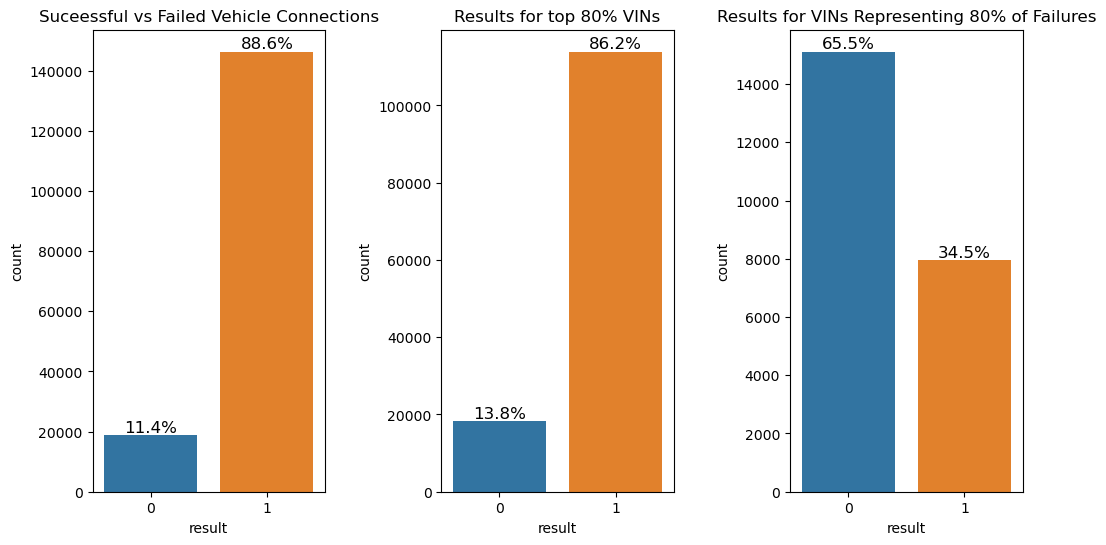

In [42]:
titles = ['Suceessful vs Failed Vehicle Connections', 'Results for top 80% VINs', 'Results for VINs Representing 80% of Failures']
#df = [diag_usage_df, diag_usage_df_vins_80, diag_usage_df_years_80, diag_usage_df_makes_80, diag_usage_df_models_80, failed_vins_df_80]
df = [diag_usage_df, diag_usage_df_vins_80, failed_vins_df_80]
plot_multiple_countplots(df, titles, 'result')

Text(0.5, 1.0, 'Distribution of scans per year')

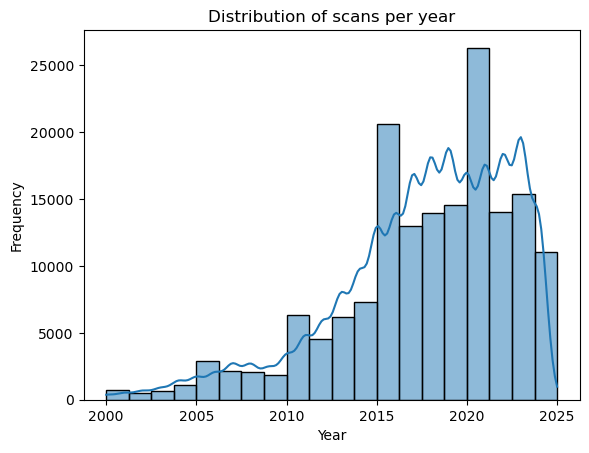

In [43]:
#plot distribution of year value counts
sns.histplot(diag_usage_df['year'], kde=True, bins=20)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Distribution of scans per year')

## Look at overall scanning success rates for shops by siteId

In [44]:
# Get the number of unique shops
unique_shops_count = diag_usage_df['siteId'].nunique()
print(f"Number of unique siteIds: {unique_shops_count}")

# Group by siteId and calculate metrics
shops_df = diag_usage_df.groupby('siteId').apply(lambda group: pd.Series({
    'shop_type': group['product_type'].iloc[0],
    'total_scans': group['result'].count(),              # Total scans by this shop
    'num_success': group['result'].sum(),              # Number of successes (1 = success)
    'vins_success': group.loc[group['result'] == 1, 'vin'].nunique(),  # Unique vins with successful scans
    'vins_failure': group.loc[group['result'] == 0, 'vin'].nunique()   # Unique vins with failed scans
})).reset_index()

# Calculate the number of failures and rates
shops_df['num_failed'] = shops_df['total_scans'] - shops_df['num_success']
shops_df['success_rate'] = (shops_df['num_success'] / shops_df['total_scans']) * 100
shops_df['failure_rate'] = (shops_df['num_failed'] / shops_df['total_scans']) * 100

# Display the statistics for each shop
shops_df.sample(10)

Number of unique siteIds: 1695


,siteId,shop_type,total_scans,num_success,vins_success,vins_failure,num_failed,success_rate,failure_rate
1132,606347,COLLISION,59,57,27,2,2,96.610169,3.389831
1287,682623,REPAIR,29,28,8,1,1,96.551724,3.448276
587,334607,REPAIR,12,10,7,1,2,83.333333,16.666667
1110,589615,REPAIR,4,4,4,0,0,100.000000,0.000000
676,379374,COLLISION,33,33,20,0,0,100.000000,0.000000
311,186594,REPAIR,51,49,32,2,2,96.078431,3.921569
657,370291,COLLISION,220,202,137,7,18,91.818182,8.181818
91,60555,COLLISION,8,7,5,1,1,87.500000,12.500000
703,395294,COLLISION,25,20,17,2,5,80.000000,20.000000
1115,591931,COLLISION,363,342,178,8,21,94.214876,5.785124


<Axes: xlabel='total_scans', ylabel='Count'>

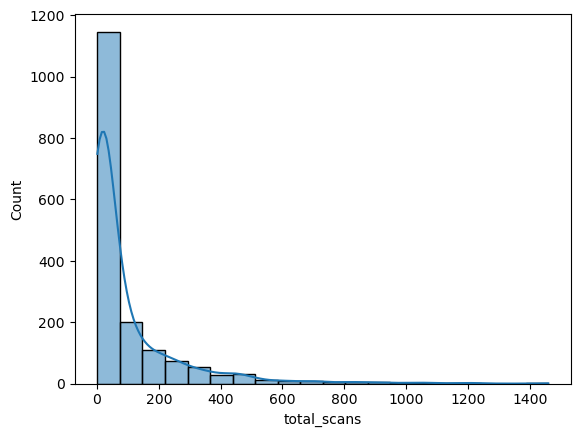

In [45]:
#look at the distribution of number of scans by siteId
sns.histplot(shops_df['total_scans'], kde=True, bins=20)

In [46]:
shops_df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
siteId,1695.0,460359.94,250513.91,10799.0,241407.00,467451.00,676217.00,888822.0
total_scans,1695.0,97.47,163.13,1.0,8.00,31.00,109.00,1460.0
num_success,1695.0,86.33,145.33,0.0,7.00,26.00,98.00,1396.0
vins_success,1695.0,49.26,81.73,0.0,4.00,15.00,58.50,753.0
vins_failure,1695.0,3.85,7.13,0.0,0.00,1.00,4.00,113.0
num_failed,1695.0,11.14,25.67,0.0,0.00,3.00,11.00,536.0
success_rate,1695.0,87.59,16.95,0.0,83.16,92.86,100.00,100.0
failure_rate,1695.0,12.41,16.95,0.0,0.00,7.14,16.84,100.0


In [47]:
#find number and percentage of siteIds that only performed one scan
one_scan_shops = shops_df[shops_df['total_scans'] == 1]
num_one_scan_shops = one_scan_shops.shape[0]
percentage_one_scan_shops = (num_one_scan_shops / unique_shops_count) * 100
print(f'Number of shops with only one scan: {num_one_scan_shops}')
print(f'Percentage of shops with only one scan: {percentage_one_scan_shops}')
#repeat for shops with less than 10 scans
less_than_10_scans = shops_df[shops_df['total_scans'] < 10]
num_less_than_10_scans = less_than_10_scans.shape[0]
percentage_less_than_10_scans = (num_less_than_10_scans / unique_shops_count) * 100
print(f'Number of shops with less than 10 scans: {num_less_than_10_scans}')
print(f'Percentage of shops with less than 10 scans: {percentage_less_than_10_scans}')

Number of shops with only one scan: 104
Percentage of shops with only one scan: 6.1356932153392325
Number of shops with less than 10 scans: 472
Percentage of shops with less than 10 scans: 27.846607669616517


<Axes: xlabel='success_rate', ylabel='Count'>

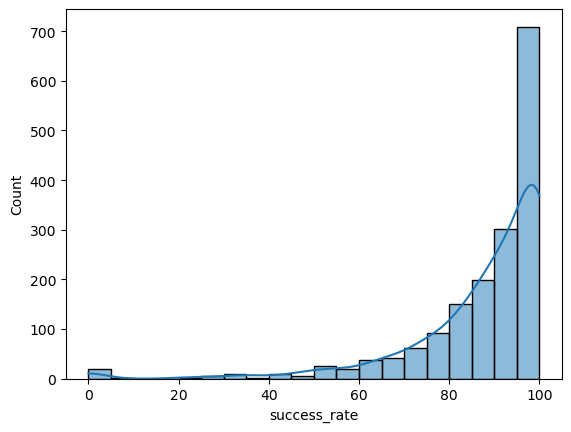

In [48]:
#create distribution plot of success rate
sns.histplot(shops_df['success_rate'], kde=True, bins=20)

In [49]:
#get breakdown of shops by shop type
shop_type_counts = shops_df['shop_type'].value_counts(normalize=True) * 100 
shop_type_counts

shop_type
COLLISION    48.141593
REPAIR       46.607670
unknown       5.250737
Name: proportion, dtype: float64

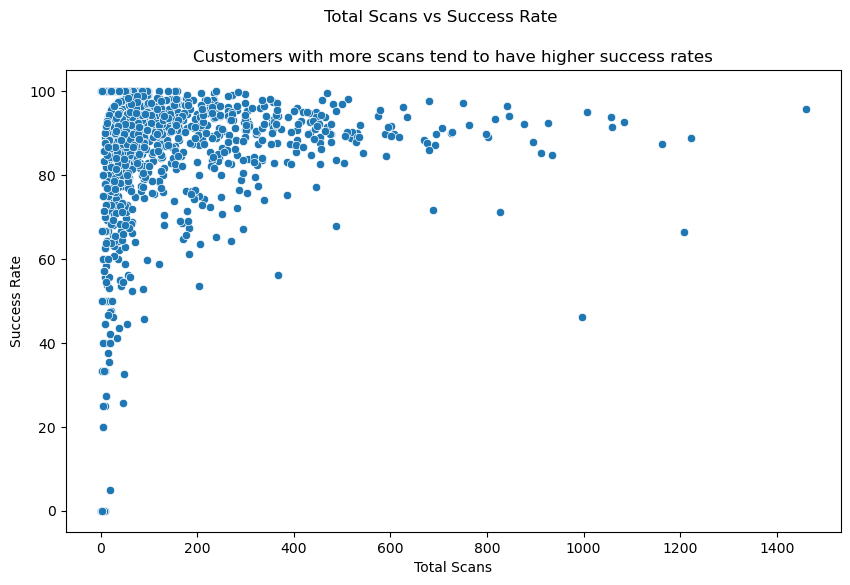

In [50]:
 #do higher number of scans correlate with higher success rates?
# Create a scatter plot of total scans vs success rate
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_scans', y='success_rate', data=shops_df)
plt.xlabel('Total Scans')
plt.ylabel('Success Rate')
plt.suptitle('Total Scans vs Success Rate')
plt.title('Customers with more scans tend to have higher success rates')
plt.show()

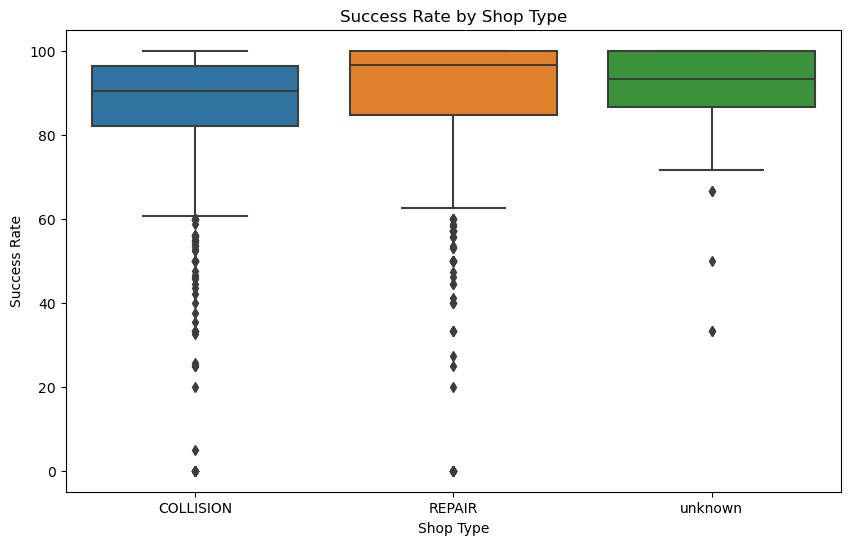

In [51]:
#Which type of shop has the highest success rate?
plt.figure(figsize=(10, 6))
sns.boxplot(x='shop_type', y='success_rate', data=shops_df)
plt.xlabel('Shop Type')
plt.ylabel('Success Rate')
plt.title('Success Rate by Shop Type')
plt.show()

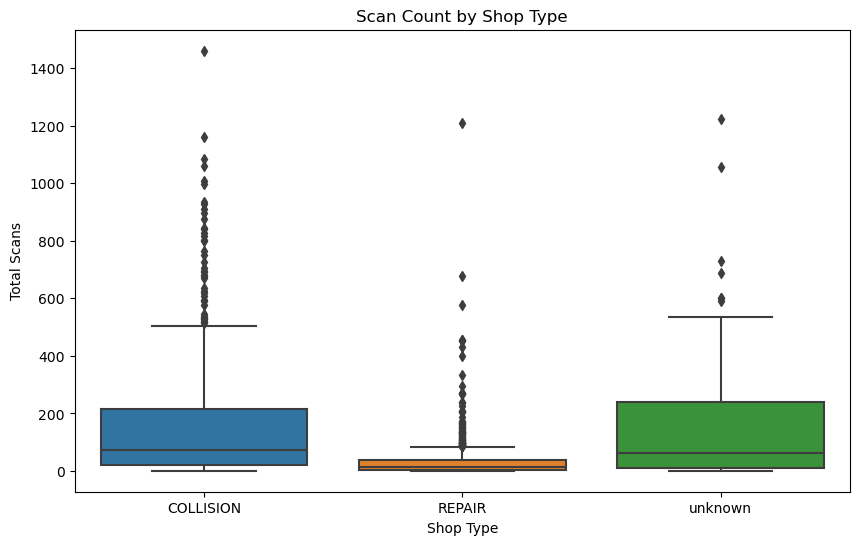

In [52]:
#Which type of shop does the most scans? 
plt.figure(figsize=(10, 6))
sns.boxplot(x='shop_type', y='total_scans', data=shops_df)
plt.xlabel('Shop Type')
plt.ylabel('Total Scans')
plt.title('Scan Count by Shop Type')
plt.show()

## Look at all VINs that do not have any successful scans

In [53]:
#create dataframe of failed scans for vins that have no successful scans
vin_max = diag_usage_df.groupby('vin')['result'].max()

# Select VINs where the max result is 0 (i.e., all records have a result of 0)
unique_vins = vin_max[vin_max == 0].index.tolist()
#len(unique_vins)
#get records where vin is in unique_vins list
all_failed_vins_df = diag_usage_df[diag_usage_df['vin'].isin(unique_vins)]
print('Information for vins with only failed scans')
print_unique_attributes(all_failed_vins_df)


Information for vins with only failed scans
Number of entries: 5909
Number of unique years: 26
Number of unique makes: 37
Number of unique models: 265
Number of unique vins: 1569
Number of unique veh_descs: 850


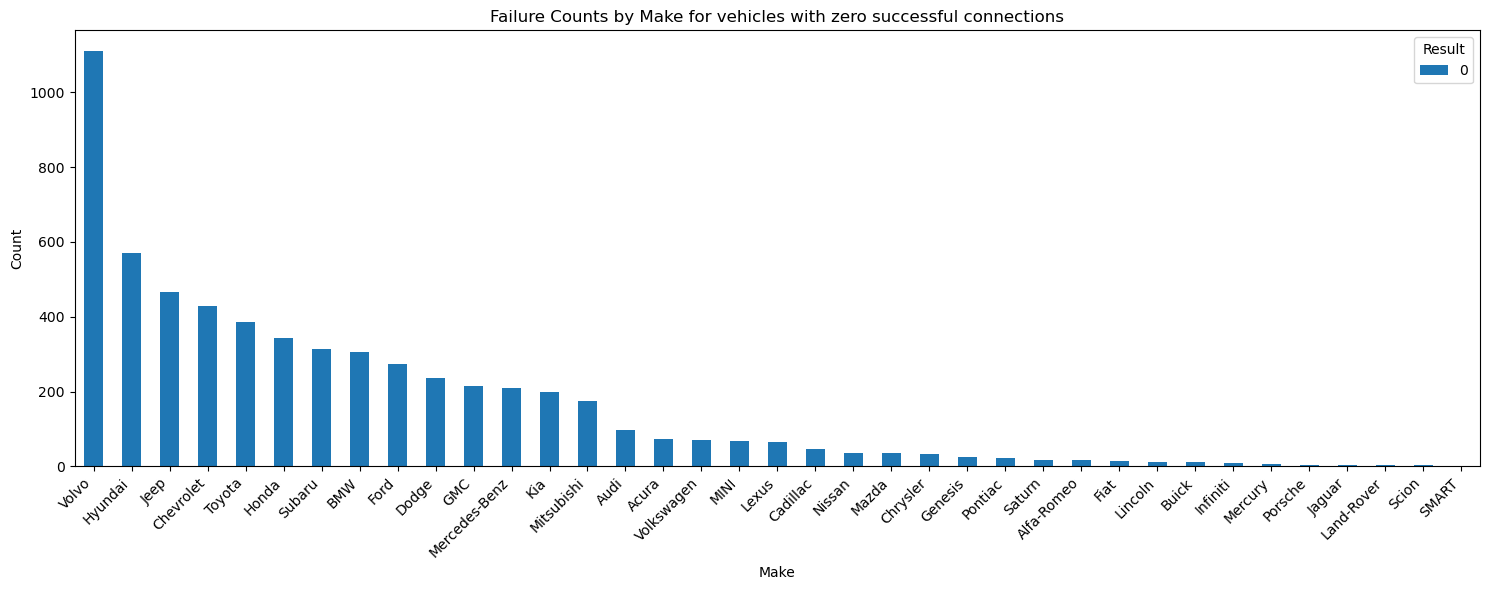

In [54]:
#create barplot of success and failure counts for connections by make
df = all_failed_vins_df.groupby(['make', 'result']).size().unstack(fill_value=0).sort_values(by=0, ascending=False)
df.plot(kind='bar', stacked=False, figsize=(15, 6))
plt.title('Failure Counts by Make for vehicles with zero successful connections')
plt.xlabel('Make')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Result')
plt.tight_layout()
plt.show()
#makes_df.head()

In [55]:
#find how many records for each vin in all_failed_vins_df
vin_counts = all_failed_vins_df['vin'].value_counts()
vin_counts.describe()

count    1569.000000
mean        3.766093
std         3.685600
min         1.000000
25%         2.000000
50%         3.000000
75%         5.000000
max        39.000000
Name: count, dtype: float64

In [56]:
#Get the frequency of failed scans for shops that have scanned vehicles with no successful connections
shops = all_failed_vins_df['siteId'].value_counts()
shops.describe()

count    681.000000
mean       8.676946
std       10.909988
min        1.000000
25%        2.000000
50%        5.000000
75%       11.000000
max      114.000000
Name: count, dtype: float64

In [57]:
#For each VIN in all_failed_vins_df, vehicle description, total_failures and num_shops that scanned that vin:
vin_summary_df = all_failed_vins_df.groupby('vin').agg(
    veh_desc=('veh_desc', 'first'),         # Assuming veh_desc is the same for each VIN
    total_failures=('vin', 'size'),         # Count of records (failures) per VIN
    num_shops=('siteId', 'nunique')         # Unique shop count per VIN
).reset_index()

print(f'Number of unique VINs with all failures: {vin_summary_df.shape[0]}')

one_scan_summary_df = vin_summary_df[vin_summary_df['total_failures'] == 1]
print(f'Number of VINs with single failure and no successful scans: {one_scan_summary_df.shape[0]}')

one_shop_summary_df = vin_summary_df[vin_summary_df['num_shops'] == 1]
print(f'Number of VINs with failures at only one shop: {one_shop_summary_df.shape[0]}')

multi_shop_summary_df = vin_summary_df[vin_summary_df['num_shops'] > 1]
print(f'Number of VINs with failures at multiple shops: {multi_shop_summary_df.shape[0]}')
multi_shop_summary_df.to_excel('../Data/MultiShopFailures.xlsx', sheet_name='multi_shop_failures', index=False)
multi_shop_summary_df.head(5)

Number of unique VINs with all failures: 1569
Number of VINs with single failure and no successful scans: 382
Number of VINs with failures at only one shop: 1515
Number of VINs with failures at multiple shops: 54


,vin,veh_desc,total_failures,num_shops
40,1C4RJFAG6NC,2022 Jeep Grand,10,2
46,1C4RJFBG8NC,2022 Jeep Grand,16,2
54,1C4RJKBG9M8,2021 Jeep Grand,17,3
55,1C4RJKBGXM8,2021 Jeep Grand,12,2
57,1C4RJKDG2M8,2021 Jeep Grand,6,2


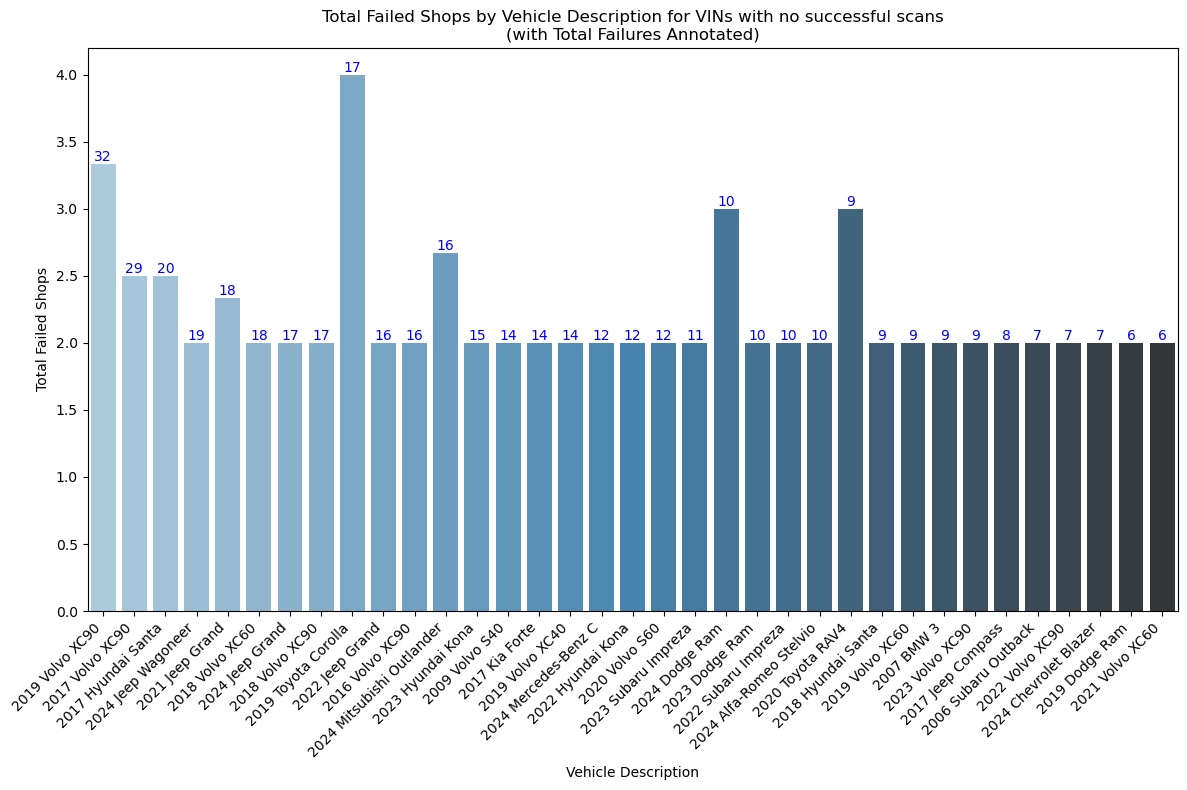

In [58]:
#create barplot of total shop failures for each vehicle description in multi_shop_summary_df

multi_shop_summary_df = multi_shop_summary_df.sort_values('total_failures', ascending=False)

# Create a bar chart with veh_desc on the x-axis and total_failed_shops as the y-axis
plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(x='veh_desc', y='num_shops', data=multi_shop_summary_df, palette='Blues_d', ci=None)

# Annotate each bar with the total_failures value
for p, (_, row) in zip(bar_plot.patches, multi_shop_summary_df.iterrows()):
    # Calculate the center of the bar
    x = p.get_x() + p.get_width() / 2.
    y = p.get_height()
    bar_plot.text(x, y, f"{row.total_failures}", ha='center', va='bottom', color='blue')

plt.xlabel("Vehicle Description")
plt.ylabel("Total Failed Shops")
plt.title("Total Failed Shops by Vehicle Description for VINs with no successful scans\n(with Total Failures Annotated)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [59]:
#for each shop count number of failed vins
failed_shops_df = all_failed_vins_df.groupby('siteId')['vin'].nunique().reset_index(name='count')
#For each shop count total number of failed scans
failed_shops_df['total_failures'] = all_failed_vins_df.groupby('siteId')['result'].count().values
failed_shops_df = failed_shops_df.sort_values(by='count', ascending=False)

#find siteId from shops_df and add success rate and shop type to failed_shops_df
success_rate_map = shops_df.set_index('siteId')['success_rate'].to_dict()
shop_type_map = shops_df.set_index('siteId')['shop_type'].to_dict()

failed_shops_df['success_rate'] = failed_shops_df['siteId'].map(success_rate_map)
failed_shops_df['shop_type'] = failed_shops_df['siteId'].map(shop_type_map)

#sort by success rate lowest to highest
failed_shops_df = failed_shops_df.sort_values(by='success_rate')

failed_shops_df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
siteId,681.0,466562.31,247639.17,12681.0,252404.00,471492.00,680250.00,888594.00
count,681.0,2.41,2.33,1.0,1.00,2.00,3.00,21.00
total_failures,681.0,8.68,10.91,1.0,2.00,5.00,11.00,114.00
success_rate,681.0,81.02,17.78,0.0,76.92,86.84,91.81,99.65


## Investigate metrics per unique VIN

In [60]:
# Get the number of unique VINs scanned at that site
unique_vins_count = diag_usage_df['vin'].nunique()
#print(f"Number of unique VINs at site {site_id_value}: {unique_vins_count}")
print(f"Number of unique VINs: {unique_vins_count}")

# Group by VIN and calculate metrics
vin_stats_df = diag_usage_df.groupby('vin').apply(lambda group: pd.Series({
    'total': group['result'].count(),              # Total scans per VIN
    'num_success': group['result'].sum(),              # Number of successes (assuming 1 = success)
    'shops_success': group.loc[group['result'] == 1, 'siteId'].nunique(),  # Unique shops with result = 1
    'shops_failure': group.loc[group['result'] == 0, 'siteId'].nunique()   # Unique shops with result = 0
})).reset_index()

# Calculate the number of failures and rates
vin_stats_df['num_failed'] = vin_stats_df['total'] - vin_stats_df['num_success']
vin_stats_df['success_rate'] = (vin_stats_df['num_success'] / vin_stats_df['total']) * 100
vin_stats_df['failure_rate'] = (vin_stats_df['num_failed'] / vin_stats_df['total']) * 100

# Display the statistics for each VIN
vin_stats_df.sample(5)

Number of unique VINs: 61808


,vin,total,num_success,shops_success,shops_failure,num_failed,success_rate,failure_rate
57619,SALYL2RV5JA,2,2,1,0,0,100.0,0.0
1651,1C4PJMDN5KD,3,3,1,0,0,100.0,0.0
25443,2T1BU4EE0CC,7,7,4,0,0,100.0,0.0
52729,JTMWFREV5JJ,2,2,1,0,0,100.0,0.0
4771,1FATP8UH5M5,2,2,1,0,0,100.0,0.0


In [61]:
vin_stats_df.describe()

,total,num_success,shops_success,shops_failure,num_failed,success_rate,failure_rate
count,61808.000000,61808.000000,61808.000000,61808.000000,61808.000000,61808.000000,61808.000000
mean,2.673084,2.367509,1.350828,0.105488,0.305575,94.138477,5.861523
std,2.557015,2.130732,0.907795,0.330868,1.377091,20.046686,20.046686
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,0.000000,0.000000,100.000000,0.000000
50%,2.000000,2.000000,1.000000,0.000000,0.000000,100.000000,0.000000
75%,3.000000,3.000000,1.000000,0.000000,0.000000,100.000000,0.000000
max,43.000000,42.000000,15.000000,5.000000,39.000000,100.000000,100.000000


### Look at overall success rate and success rate by VCI version and connection method. 

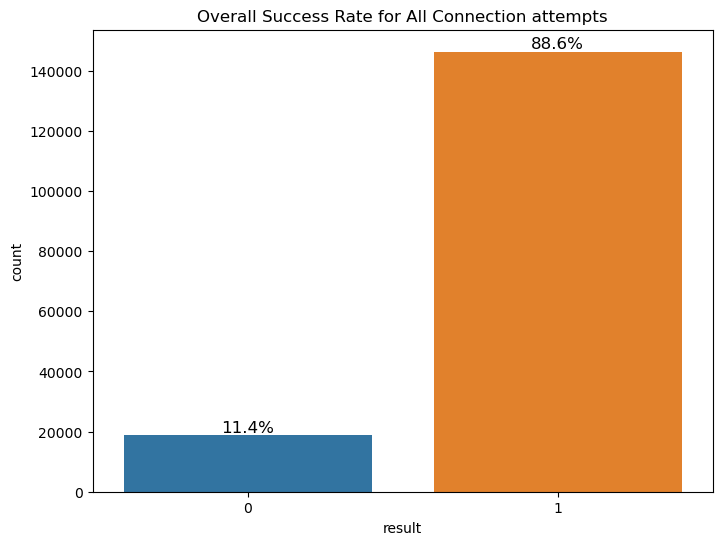

In [62]:
#create plot of overall success rate for all connections
plot_success_failure_rate(diag_usage_df, 'Overall Success Rate for All Connection attempts')

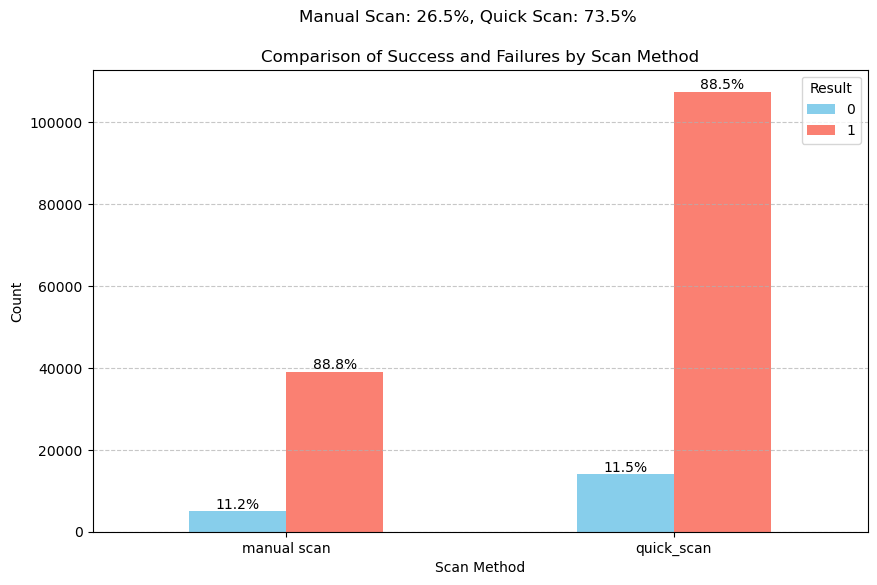

In [63]:
#compare the connection success rate based on connection method
scan_method_df = pd.crosstab(diag_usage_df['scan_method'], diag_usage_df['result'])


percentages = scan_method_df.div(scan_method_df.sum(axis=1), axis=0) * 100
ax = scan_method_df.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'salmon'])
plt.title('Comparison of Success and Failures by Scan Method')
plt.xlabel('Scan Method')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Result')

#add annotation of manual scan vs quick_scan total percentage
total_scans = diag_usage_df.shape[0]
total_manual = diag_usage_df[diag_usage_df['scan_method'] == 'manual scan'].shape[0]
total_quick_scan = diag_usage_df[diag_usage_df['scan_method'] == 'quick_scan'].shape[0]

manual_percentage = (total_manual / total_scans) * 100
quick_scan_percentage = (total_quick_scan / total_scans) * 100
# Annotate percentages as subtitle
plt.suptitle(f'Manual Scan: {manual_percentage:.1f}%, Quick Scan: {quick_scan_percentage:.1f}%', fontsize=12)

# Annotate percentages on the bars
for bar_group, percentage_group in zip(ax.containers, percentages.T.iterrows()):
    for bar, percentage in zip(bar_group, percentage_group[1]):
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # X-coordinate
            bar.get_height() + 0.5,  # Y-coordinate
            f'{percentage:.1f}%',  # Percentage text
            ha='center', va='bottom', fontsize=10  # Align text
        )

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

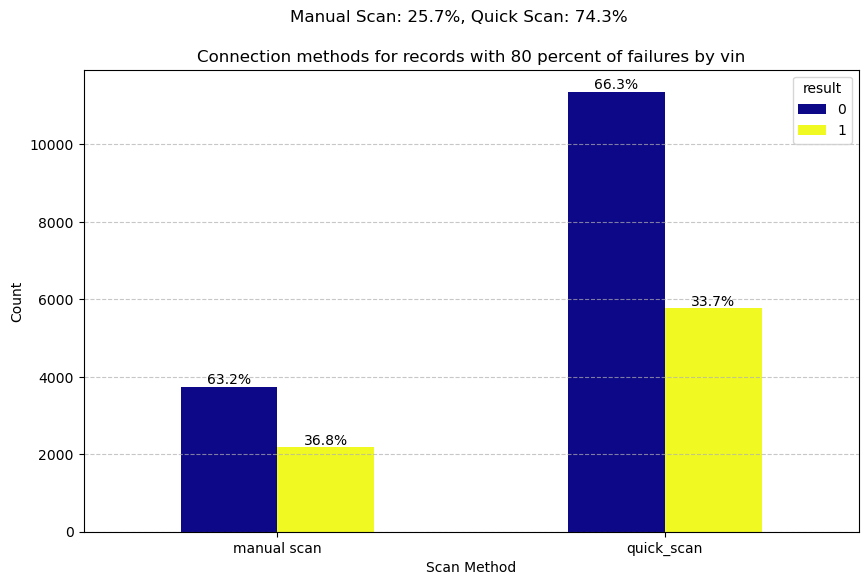

In [64]:
#compare success failure rate based on connection type for dataframe that has 80% of failures
scan_method_df = pd.crosstab(failed_vins_df_80['scan_method'], failed_vins_df_80['result'])


percentages = scan_method_df.div(scan_method_df.sum(axis=1), axis=0) * 100

ax = scan_method_df.plot(kind='bar', figsize=(10, 6), colormap='plasma')
plt.title('Connection methods for records with 80 percent of failures by vin')
plt.xlabel('Scan Method')
plt.ylabel('Count')
plt.xticks(rotation=0)

#add annotation of manual scan vs quick_scan total percentage
total_scans = failed_vins_df_80.shape[0]
total_manual = failed_vins_df_80[failed_vins_df_80['scan_method'] == 'manual scan'].shape[0]
total_quick_scan = failed_vins_df_80[failed_vins_df_80['scan_method'] == 'quick_scan'].shape[0]

manual_percentage = (total_manual / total_scans) * 100
quick_scan_percentage = (total_quick_scan / total_scans) * 100
# Annotate percentages as subtitle
plt.suptitle(f'Manual Scan: {manual_percentage:.1f}%, Quick Scan: {quick_scan_percentage:.1f}%', fontsize=12)

# Annotate percentages on the bars
for bar_group, percentage_group in zip(ax.containers, percentages.T.iterrows()):
    for bar, percentage in zip(bar_group, percentage_group[1]):
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # X-coordinate
            bar.get_height() + 0.5,  # Y-coordinate
            f'{percentage:.1f}%',  # Percentage text
            ha='center', va='bottom', fontsize=10  # Align text
        )

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [65]:
#compute percentage of total scans for each scan method
scan_method_df['total'] = scan_method_df[0] + scan_method_df[1]
overall_total = scan_method_df['total'].sum()
scan_method_df['percentage'] = (scan_method_df['total'] / overall_total) * 100
scan_method_df.head()

result,0,1,total,percentage
scan_method,,,,
manual scan,3744,2177,5921,25.687636
quick_scan,11365,5764,17129,74.312364


In [66]:
#Look at number of unique vehicle descriptions
summary_df = diag_usage_df.groupby('veh_desc')['result'].agg(total_attempts='count', total_failures=lambda x: (x == 0).sum()).reset_index()

# Calculate the failure rate
summary_df['failure_rate'] = summary_df['total_failures'] / summary_df['total_attempts'] * 100

# Sort by failure rate in descending order
#sorted_summary = summary_df.sort_values(by='failure_rate', ascending=False)

# Display the results
summary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4908 entries, 0 to 4907
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   veh_desc        4908 non-null   object 
 1   total_attempts  4908 non-null   int64  
 2   total_failures  4908 non-null   int64  
 3   failure_rate    4908 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 153.5+ KB


Text(0.5, 1.0, 'Distribution of Battery Voltage')

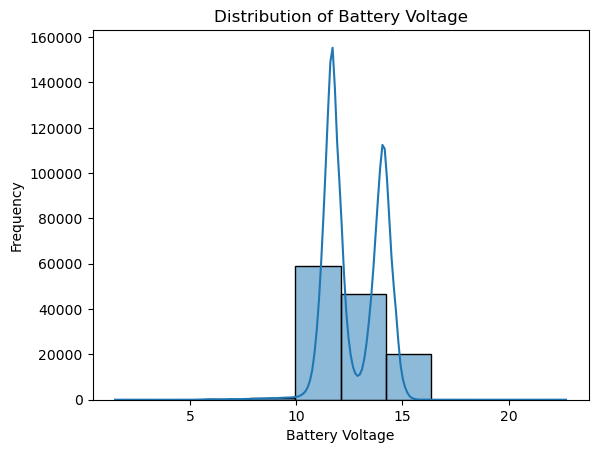

In [67]:
#distribution plot of the battery voltage
batt_voltage_df = diag_usage_df[diag_usage_df['batt_voltage'] > 0]
sns.histplot(batt_voltage_df['batt_voltage'], kde=True, bins=10)

# Add labels and title
plt.xlabel('Battery Voltage')
plt.ylabel('Frequency')
plt.title('Distribution of Battery Voltage')

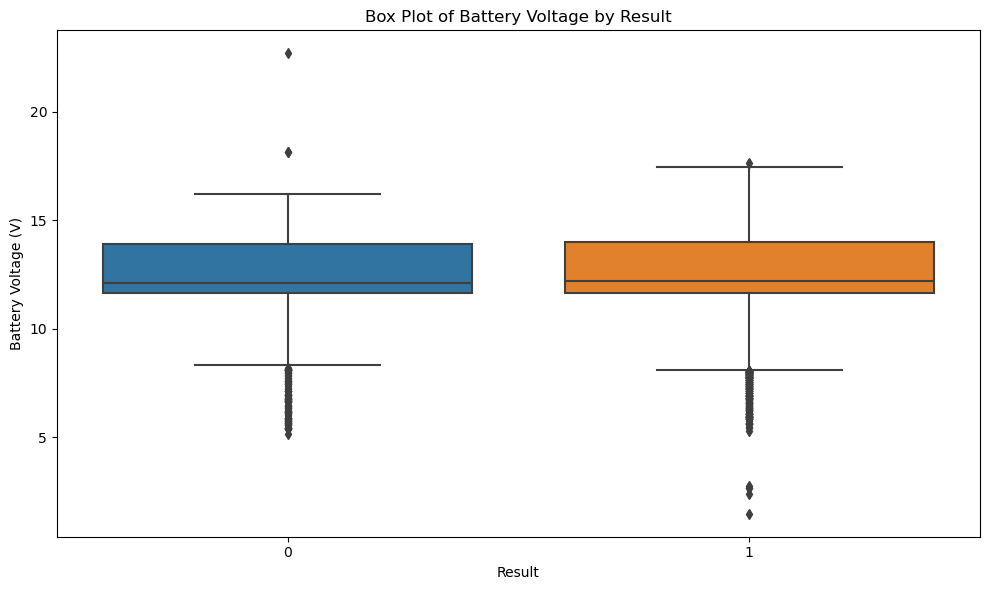

In [68]:
#Look at box plot of battery voltage by result
batt_voltage_df = diag_usage_df[diag_usage_df['batt_voltage'] > 0]
plt.figure(figsize=(10, 6))
sns.boxplot(data=batt_voltage_df, x='result', y='batt_voltage')
plt.title('Box Plot of Battery Voltage by Result')
plt.xlabel('Result')
plt.ylabel('Battery Voltage (V)')
plt.tight_layout()
plt.show()

## Investigate vehicle attributes make, model, year and system_category
Determine which makes / models have the most scans. Which ones have highest failure rates. Does success rate change by model year? 

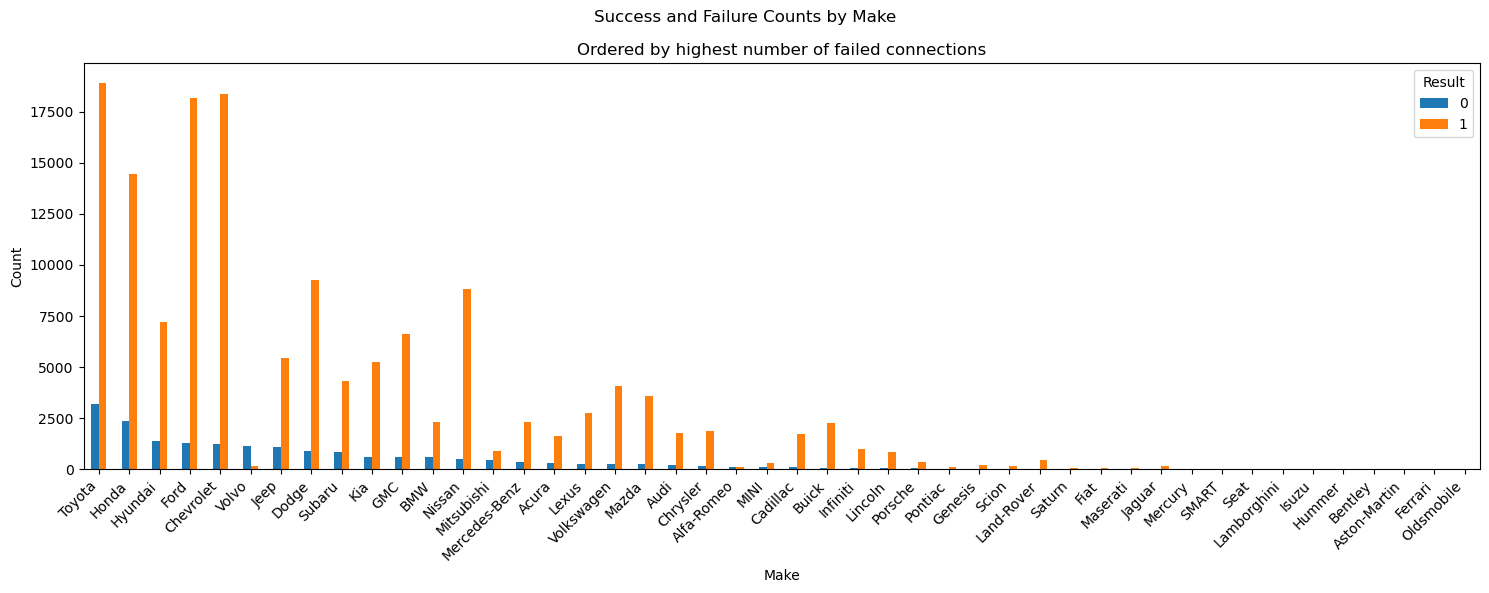

In [69]:
#create barplot of success and failure counts for connections by make
make_results_df = diag_usage_df.groupby(['make', 'result']).size().unstack(fill_value=0).sort_values(by=0, ascending=False)
make_results_df.plot(kind='bar', stacked=False, figsize=(15, 6))
plt.suptitle('Success and Failure Counts by Make')
plt.title('Ordered by highest number of failed connections')
plt.xlabel('Make')
overall_success_rate = calculate_success_rate(diag_usage_df)
plt.xlabel('Make')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Result')
plt.tight_layout()
plt.show()

In [70]:
make_results_df.reset_index(inplace=True)
make_results_df.columns

Index(['make', 0, 1], dtype='object', name='result')

In [71]:
make_results_df['success_rate'] = (make_results_df[1] /(make_results_df[1] + make_results_df[0])) * 100
make_results_df['total'] = (make_results_df[1] + make_results_df[0])
make_results_df['failure_rate'] = 100 - make_results_df['success_rate']
make_results_df

result,make,0,1,success_rate,total,failure_rate
0,Toyota,3196,18914,85.545002,22110,14.454998
1,Honda,2378,14456,85.873827,16834,14.126173
2,Hyundai,1393,7200,83.789131,8593,16.210869
3,Ford,1286,18184,93.394967,19470,6.605033
4,Chevrolet,1255,18363,93.602814,19618,6.397186
5,Volvo,1168,171,12.770724,1339,87.229276
6,Jeep,1113,5450,83.041292,6563,16.958708
7,Dodge,894,9240,91.178212,10134,8.821788
8,Subaru,835,4330,83.833495,5165,16.166505
9,Kia,613,5229,89.507018,5842,10.492982


In [72]:
make_results_df.reset_index(inplace=True)
fig = px.scatter(
    make_results_df,
    x=1,       # Successful scans
    y=0,        # Failed scans
    hover_name='make',       # On hover, show the make
    hover_data=['total', 'success_rate', 'failure_rate'],  # Additional info
    title="Success vs. Failed Scans for all Makes<br><sub>Toyota, Chevrolet, Ford and Honda dominate other makes in number of scans</sub>",
    color='make',
    labels={'1': 'Successful Scans', '0': 'Failed Scans'}
)

fig.update_traces(marker=dict(size=12), textposition='top center')
fig.show()

In [73]:
df_top12 = make_results_df.sort_values(by='total', ascending=False).head(12)
#df_top12.reset_index(inplace=True)

fig = px.scatter(
    df_top12,
    x=1,       # Successful scans
    y=0,        # Failed scans
    hover_name='make',       # On hover, show the make
    hover_data=['total', 'success_rate', 'failure_rate'],  # Additional info
    title="Success vs. Failed Scans for top Makes",
    color='make',
    labels={'1': 'Successful Scans', '0': 'Failed Scans'}
)

fig.update_traces(marker=dict(size=12), textposition='top center')
fig.show()

In [74]:
#Look at success rate by vehicle make
make_results_df['cumulative_percentage'] = make_results_df['total'].cumsum() / make_results_df['total'].sum() * 100
make_results_df = make_results_df.sort_values(by='total', ascending=False)
make_results_df.head(12)

result,index,make,0,1,success_rate,total,failure_rate,cumulative_percentage
0,0,Toyota,3196,18914,85.545002,22110,14.454998,13.382319
4,4,Chevrolet,1255,18363,93.602814,19618,6.397186,52.430728
3,3,Ford,1286,18184,93.394967,19470,6.605033,40.556719
1,1,Honda,2378,14456,85.873827,16834,14.126173,23.571282
7,7,Dodge,894,9240,91.178212,10134,8.821788,63.347214
12,12,Nissan,496,8831,94.682106,9327,5.317894,81.788304
2,2,Hyundai,1393,7200,83.789131,8593,16.210869,28.772289
10,10,GMC,607,6625,91.606748,7232,8.393252,74.386568
6,6,Jeep,1113,5450,83.041292,6563,16.958708,57.213500
9,9,Kia,613,5229,89.507018,5842,10.492982,70.009321


In [75]:
make_results_df.describe()

result,index,0,1,success_rate,total,failure_rate,cumulative_percentage
count,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000
mean,22.500000,410.586957,3181.108696,83.341352,3591.695652,16.658648,84.500202
std,13.422618,657.971988,5104.424992,20.191763,5672.618063,20.191763,22.778300
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,13.382319
25%,11.250000,13.750000,65.750000,81.441799,82.250000,6.055107,77.554352
50%,22.500000,114.000000,891.500000,88.893439,1211.500000,11.106561,95.587950
75%,33.750000,565.000000,3961.750000,93.944893,4210.000000,18.558201,99.821145
max,45.000000,3196.000000,18914.000000,100.000000,22110.000000,100.000000,100.000000


In [76]:
#Investigate scanning success rate based on VCI version
makes2_df = diag_usage_df[['make', 'vci_version', 'result']]
makes2_df.head()

,make,vci_version,result
0,Ford,22.3.2439.2,0
1,Subaru,22.1.2418.1,1
2,Honda,21.2.2323.1,1
3,Ford,22.3.2439.2,1
4,Dodge,21.3.2337.1,1


In [77]:
failures_by_vci_ver_df = makes2_df[makes2_df['result'] == 0].groupby(['make', 'vci_version']).size()
total_by_vci_ver_df = makes2_df.groupby(['make', 'vci_version']).size()
failure_percentage_df = (failures_by_vci_ver_df / total_by_vci_ver_df * 100).reset_index(name='failure_percentage')
#remove NaN values
failure_percentage_df = failure_percentage_df.dropna()
#failure_percentage_df.sample(20)

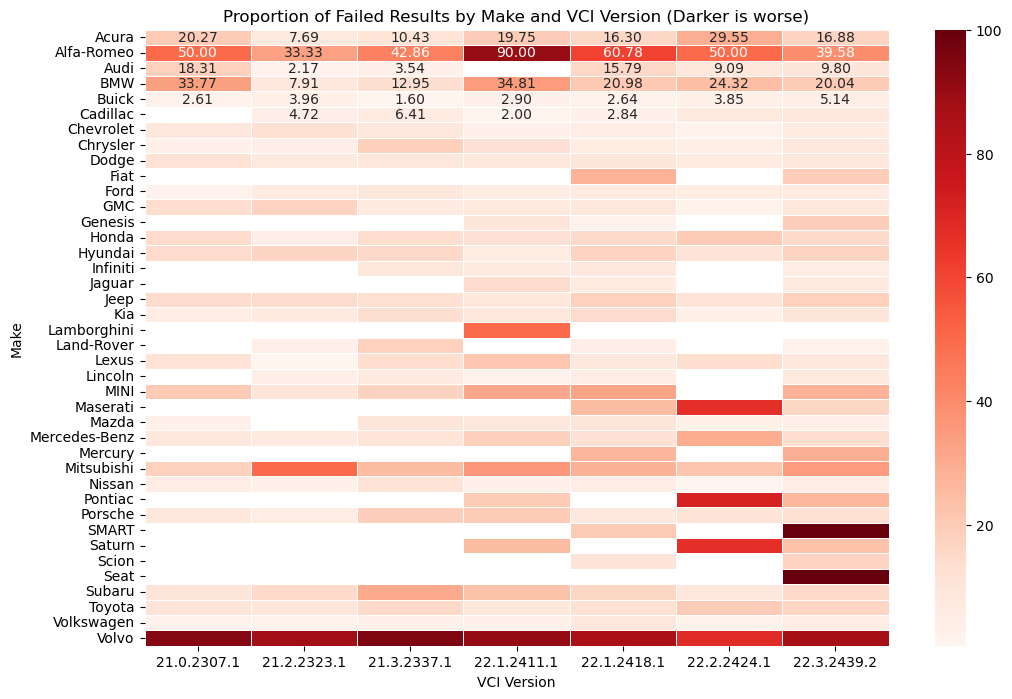

In [78]:
heatmap_data = failure_percentage_df.pivot(index="make", columns="vci_version", values="failure_percentage")
plt.figure(figsize=(12,8))
sns.heatmap(heatmap_data, annot=True, cmap="Reds", fmt=".2f", linewidths=0.5)
plt.title("Proportion of Failed Results by Make and VCI Version (Darker is worse)")
plt.xlabel("VCI Version")
plt.ylabel("Make")
plt.show()

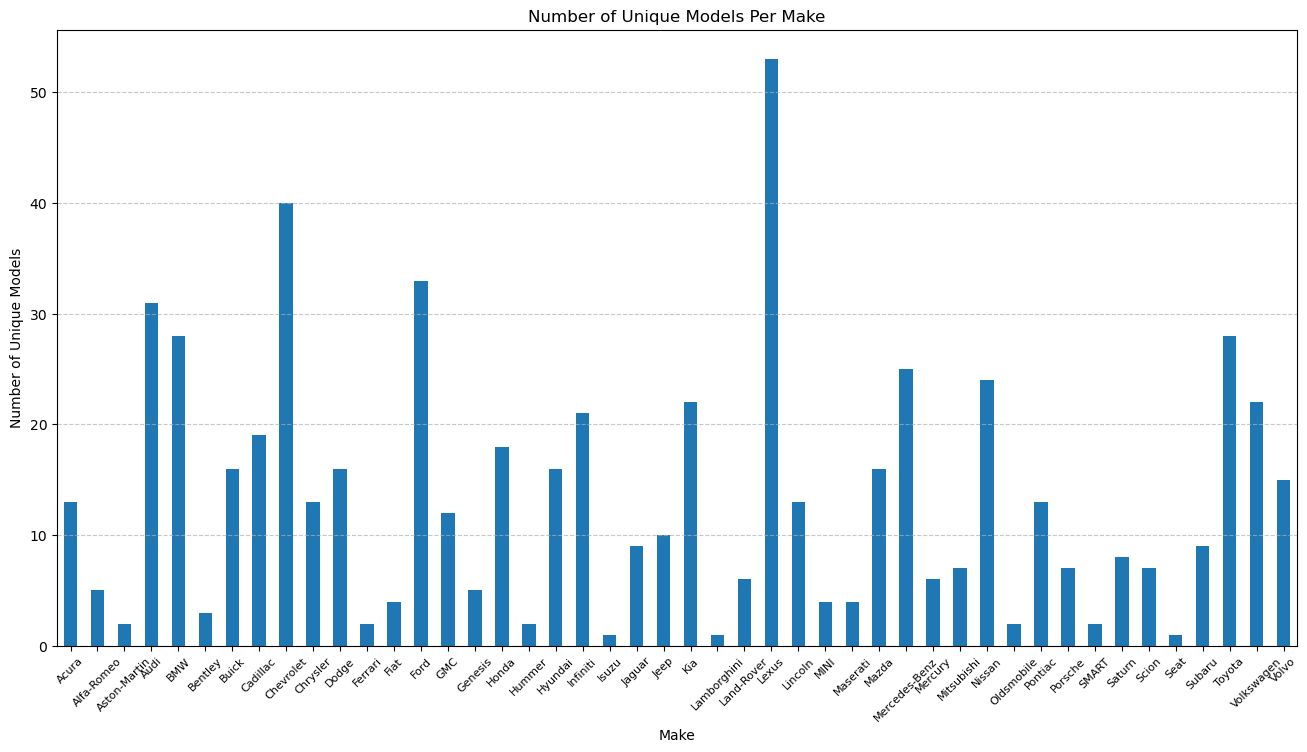

In [79]:
unique_models_per_make = diag_usage_df.groupby('make')['model'].nunique()

# Create a bar chart
plt.figure(figsize=(16, 8))
unique_models_per_make.plot(kind='bar')
plt.title('Number of Unique Models Per Make')
plt.xlabel('Make')
plt.ylabel('Number of Unique Models')
plt.xticks(rotation=45, fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [80]:
years_df = diag_usage_df.groupby(['year', 'result']).size().unstack()
years_df['success_rate'] = years_df[1] / (years_df[1] + years_df[0]) * 100
years_df['failure_rate'] = years_df[0] / (years_df[1] + years_df[0]) * 100
years_df.sample(5)
years_df.head()

result,0,1,success_rate,failure_rate
year,,,,
2000,71,227,76.174497,23.825503
2001,77,329,81.034483,18.965517
2002,70,454,86.641221,13.358779
2003,117,563,82.794118,17.205882
2004,197,918,82.331839,17.668161


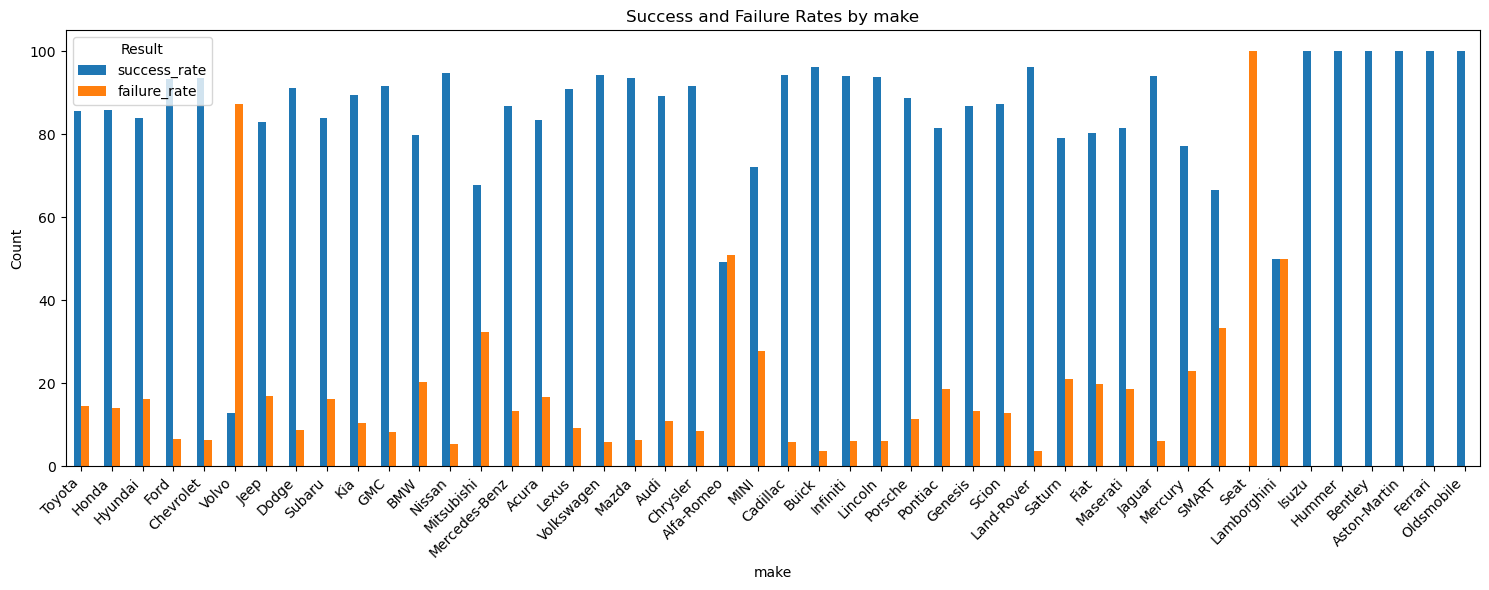

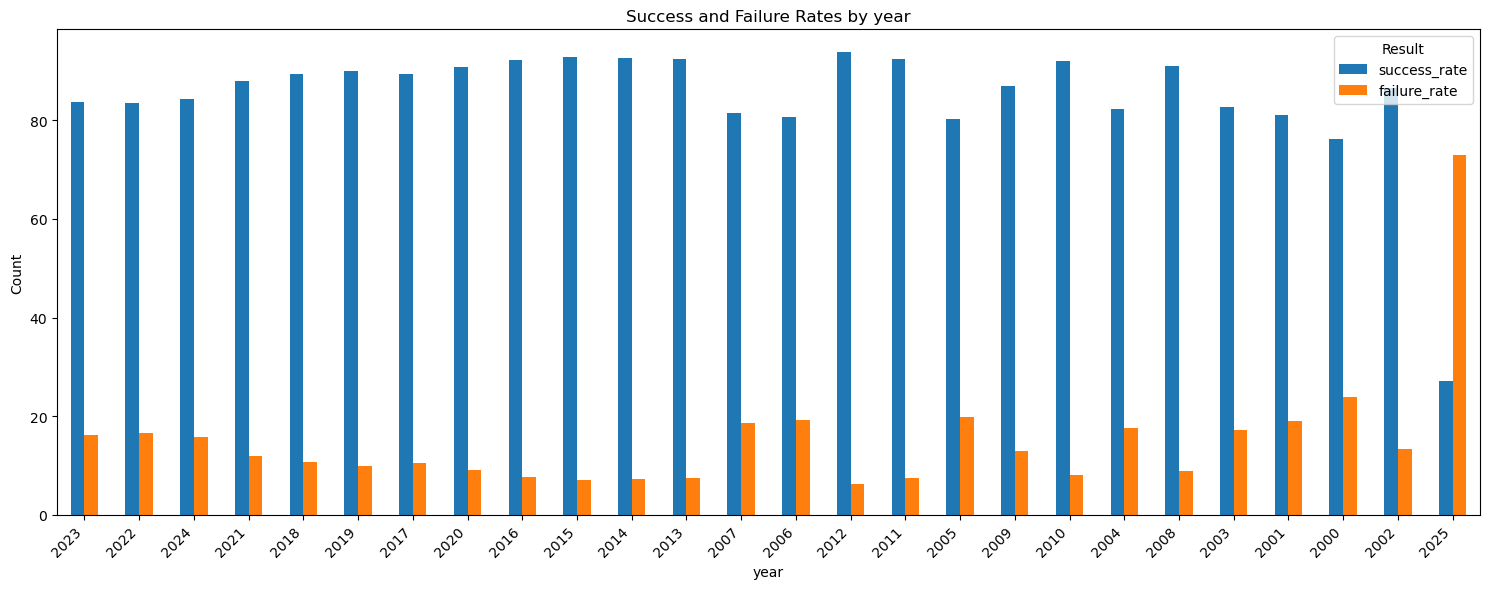

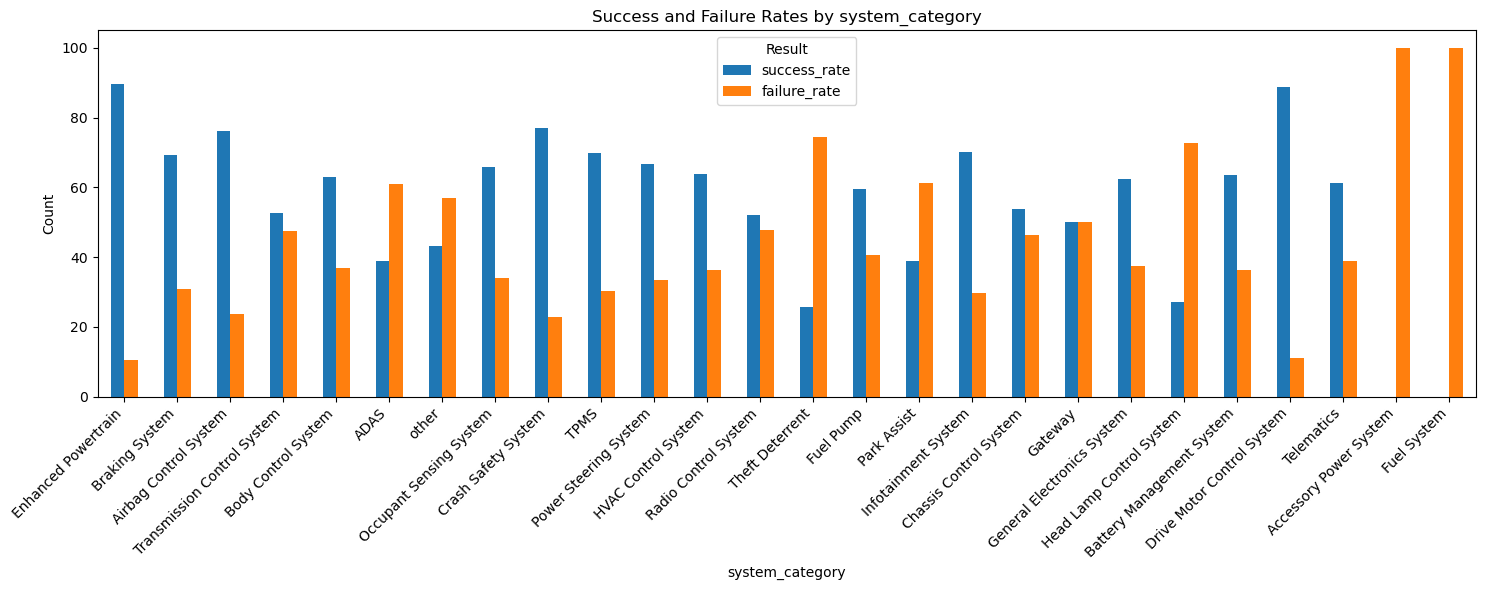

In [81]:
veh_attributes = ['make', 'year', 'system_category']
for attribute in veh_attributes:
    grouped_data = diag_usage_df.groupby([attribute, 'result']).size().unstack(fill_value=0).sort_values(by=0, ascending=False)
    grouped_data['success_rate'] = grouped_data[1] / (grouped_data[1] + grouped_data[0]) * 100
    grouped_data['failure_rate'] = grouped_data[0] / (grouped_data[1] + grouped_data[0]) * 100
    grouped_data = grouped_data[['success_rate', 'failure_rate']]
    grouped_data.plot(kind='bar', stacked=False, figsize=(15, 6))
    plt.title(f'Success and Failure Rates by {attribute}')
    plt.xlabel(attribute)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Result')
    plt.tight_layout()
    plt.show()

In [82]:
systems_df = diag_usage_df.groupby(['system_category', 'result']).size().unstack(fill_value=0).sort_values(by=0, ascending=False)
systems_df.head()

result,0,1
system_category,,
Enhanced Powertrain,16396,141374
Braking System,700,1577
Airbag Control System,409,1313
Transmission Control System,321,355
Body Control System,166,284


In [83]:
#Show heatmap with counts
def create_heat_map(data_frame, x, y, title):
    # Create a contingency table
    contingency_table = pd.crosstab(data_frame[y], data_frame[x])

    # Plot the heatmap of the contingency table
    plt.figure(figsize=(12, 6))
    sns.heatmap(contingency_table, annot=True, cmap="Reds", fmt="d", cbar=False)

    # Add labels and title
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)

    # Show the plot
    plt.tight_layout()
    plt.show()

In [84]:
#show heatmap of success rate for pass in features. Assumes diag_usage_df is already defined
def create_contingency_table_results(df, x, y, title):
    success_rate_table = df[[y, x, 'result']]
    success_rate_table = success_rate_table.groupby([y, x])['result'].mean().unstack()

    # Display the resulting table
    plt.figure(figsize=(14, 8))  # Set figure size
    sns.heatmap(success_rate_table, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Success Rate'})

    # Add labels and title
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)

    # Show the plot
    plt.tight_layout()  # Adjust layout to fit labels
    plt.show()

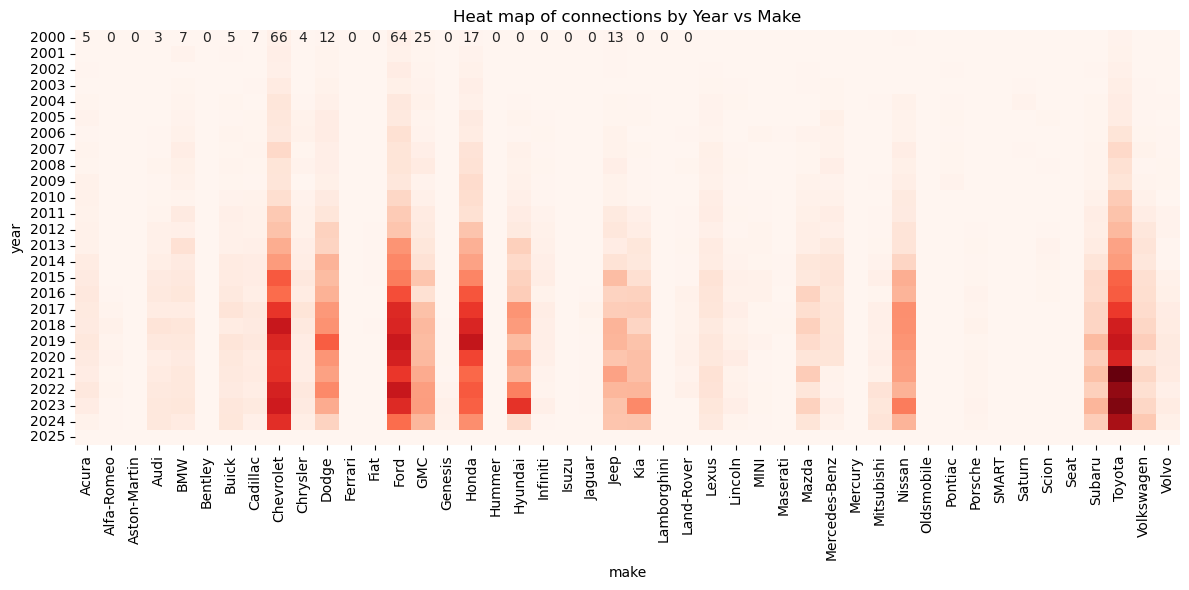

In [85]:
create_heat_map(diag_usage_df, 'make', 'year', 'Heat map of connections by Year vs Make')

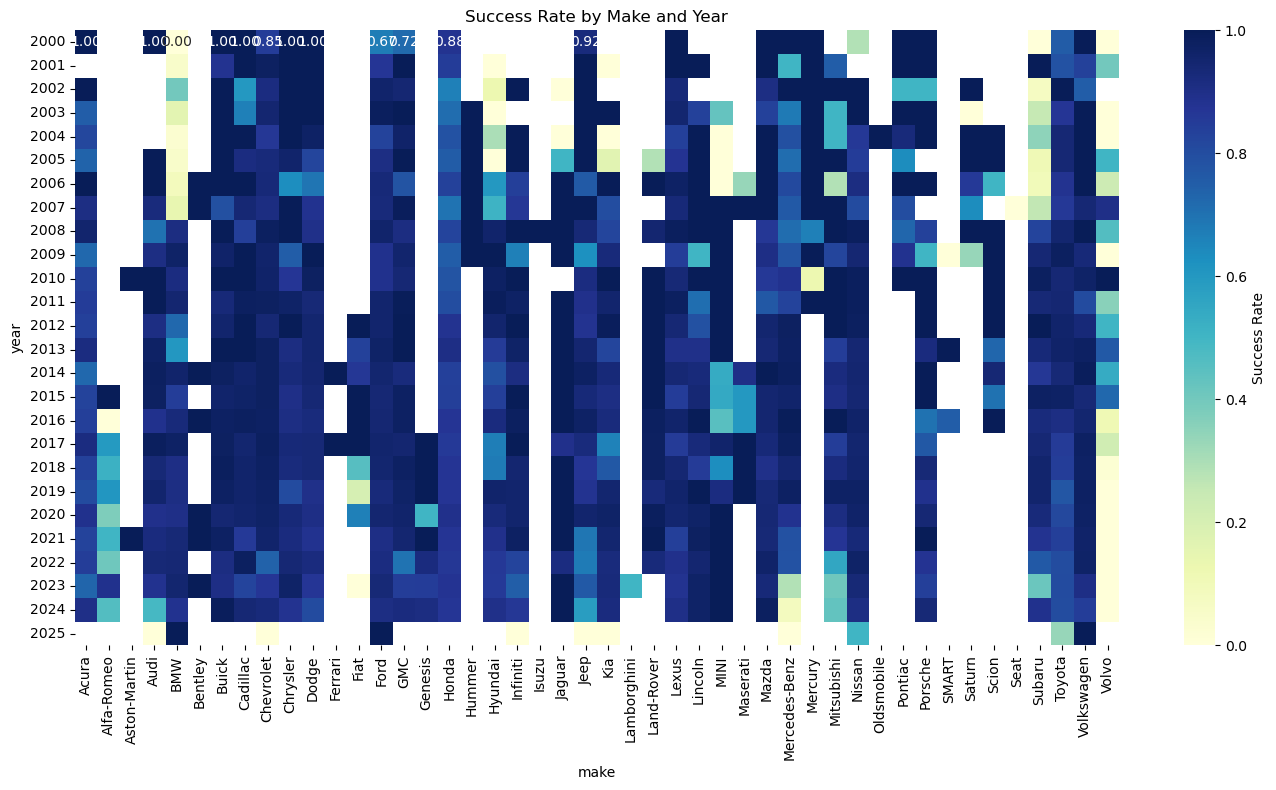

In [86]:
create_contingency_table_results(diag_usage_df, 'make', 'year', 'Success Rate by Make and Year')

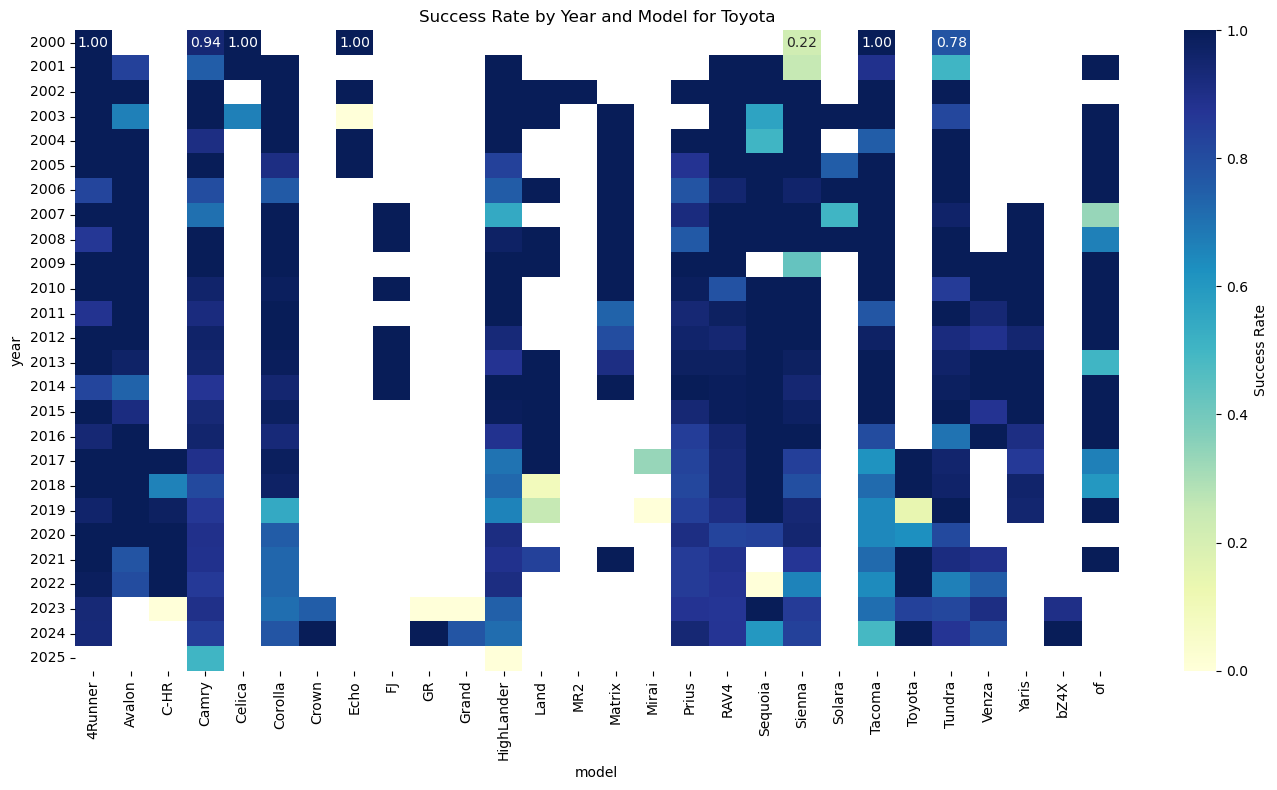

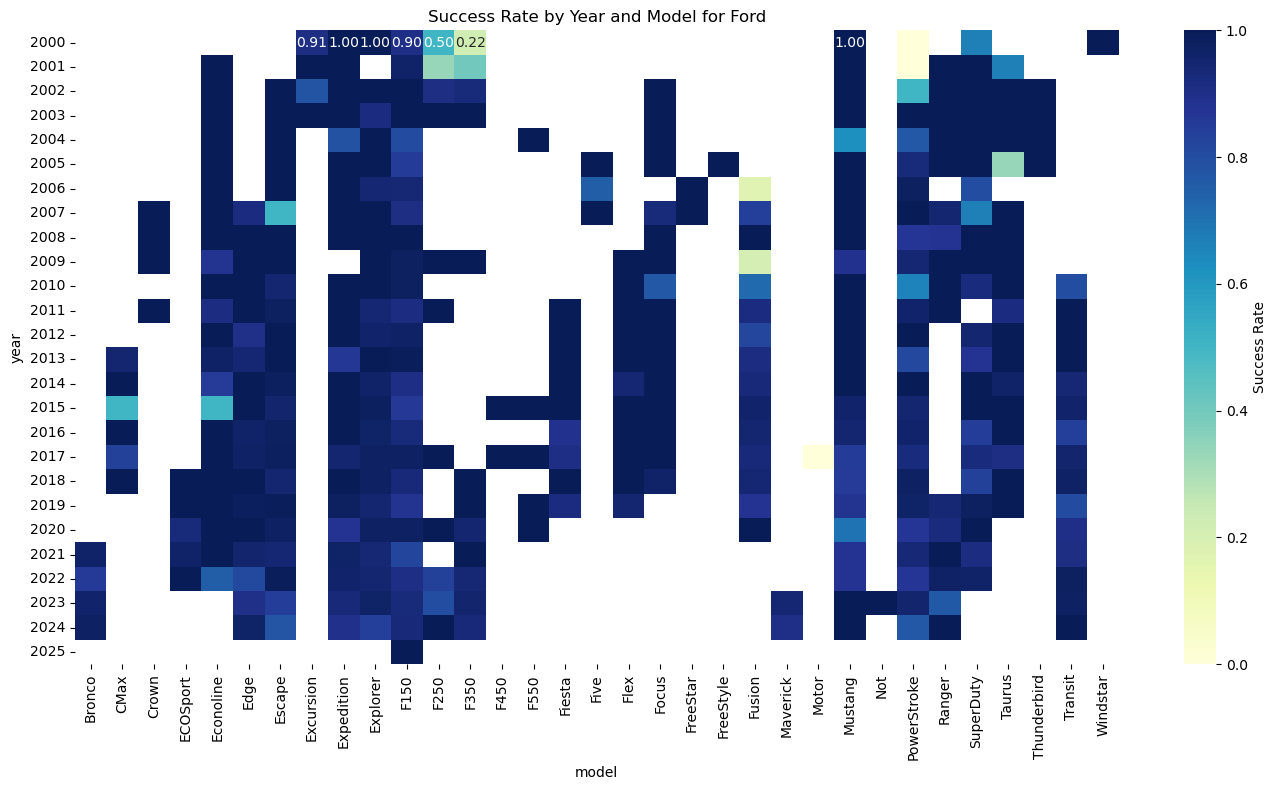

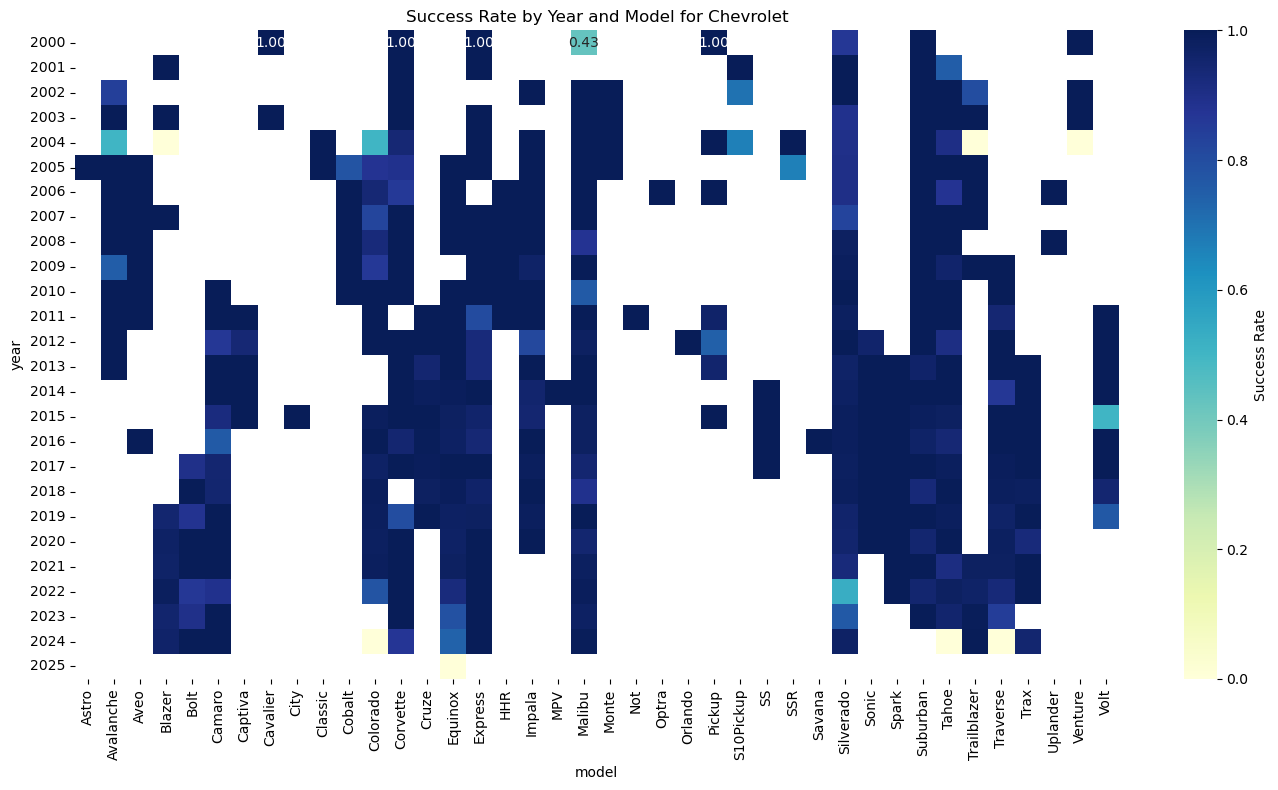

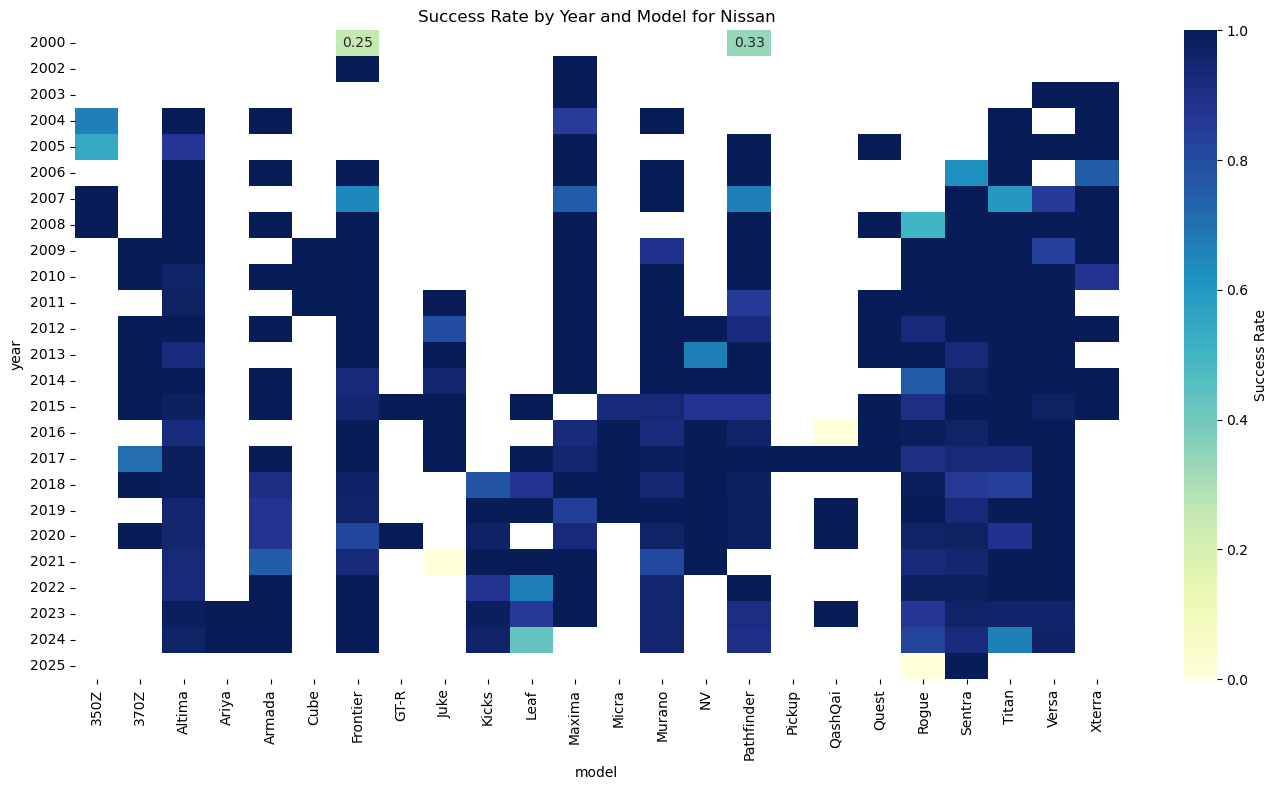

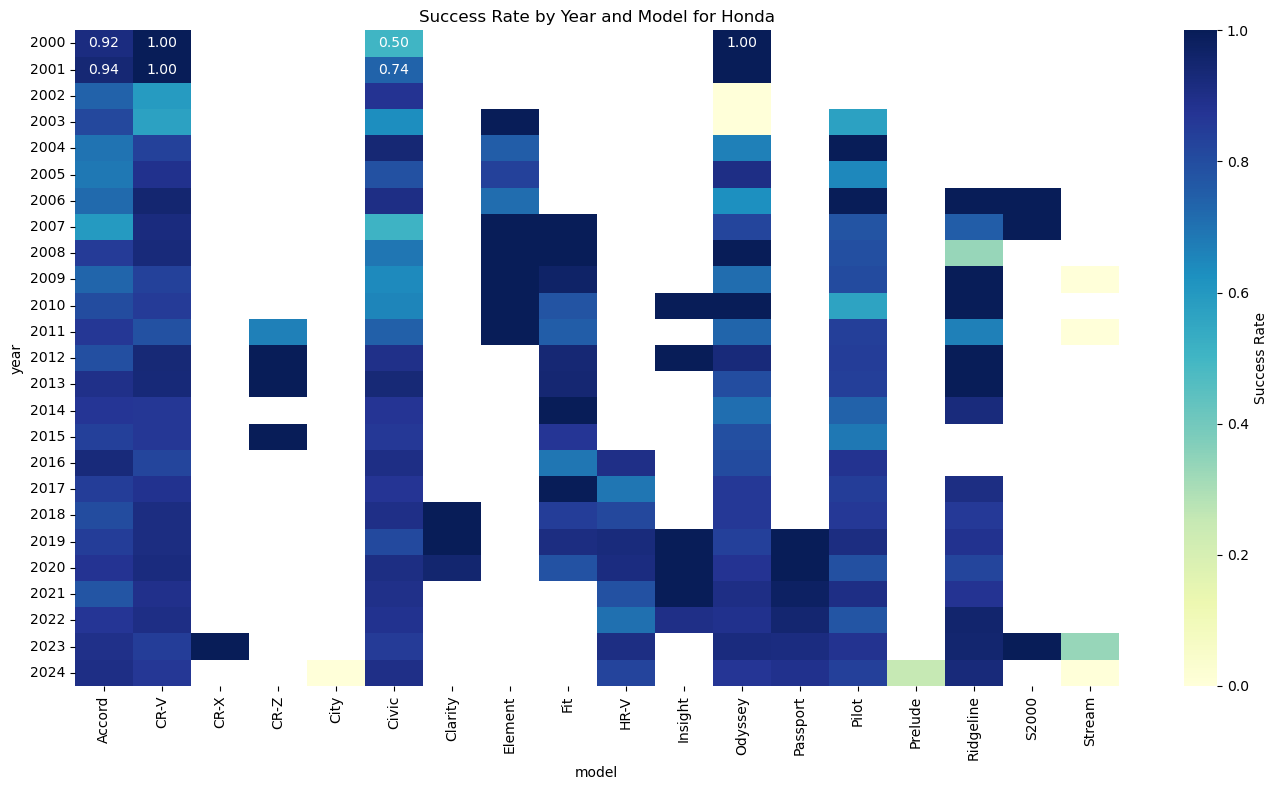

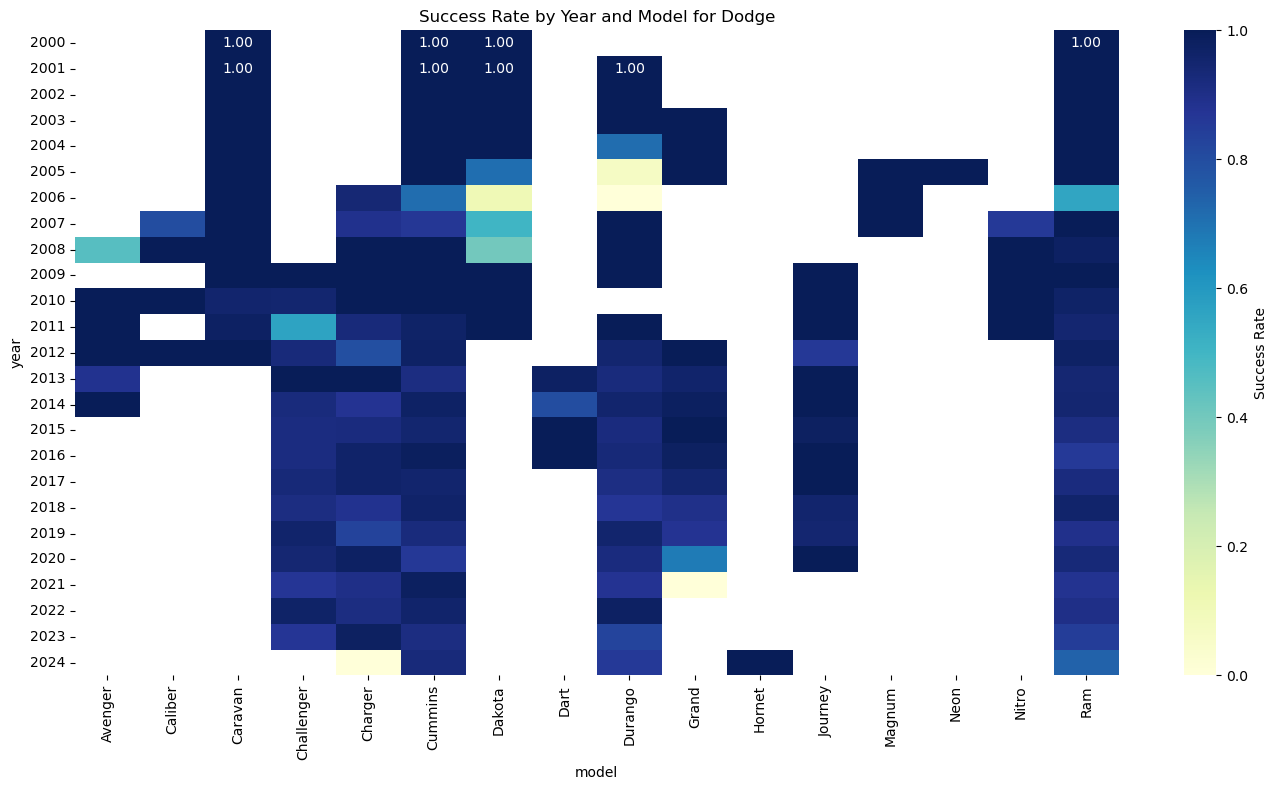

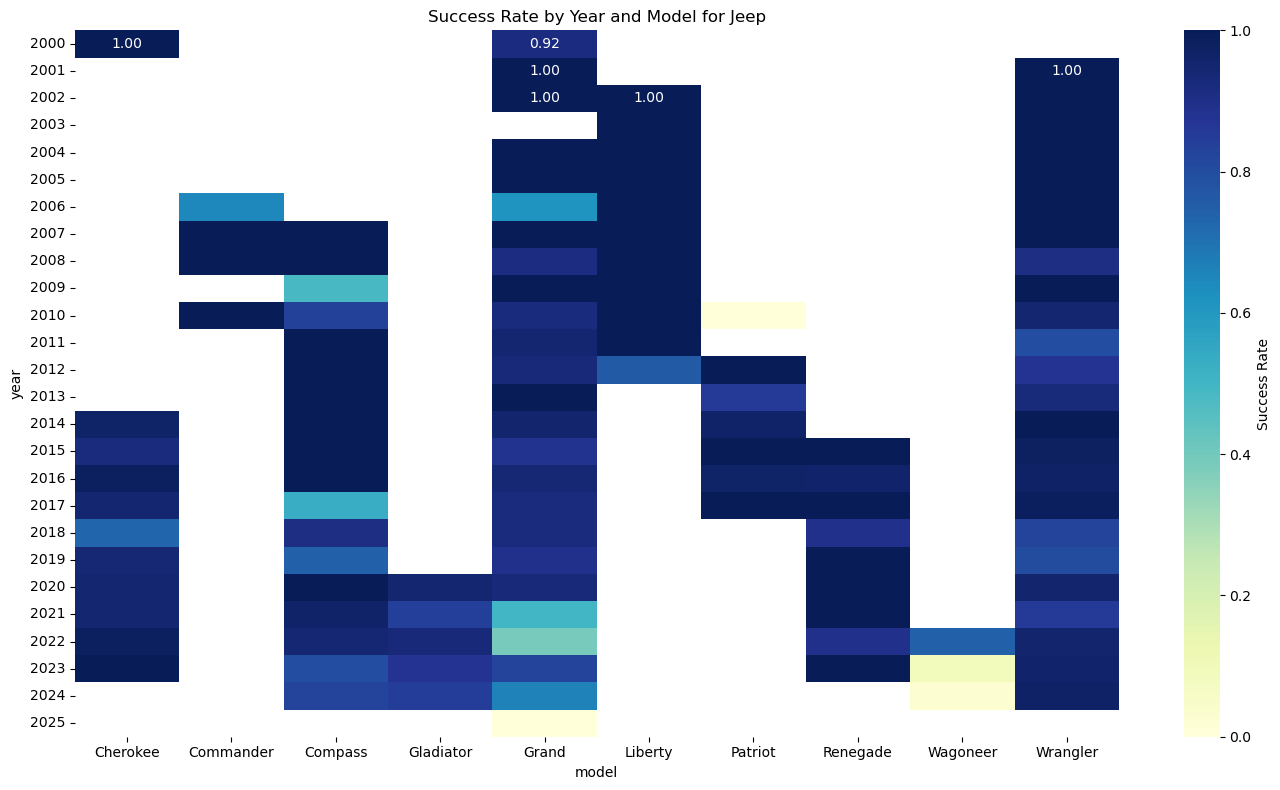

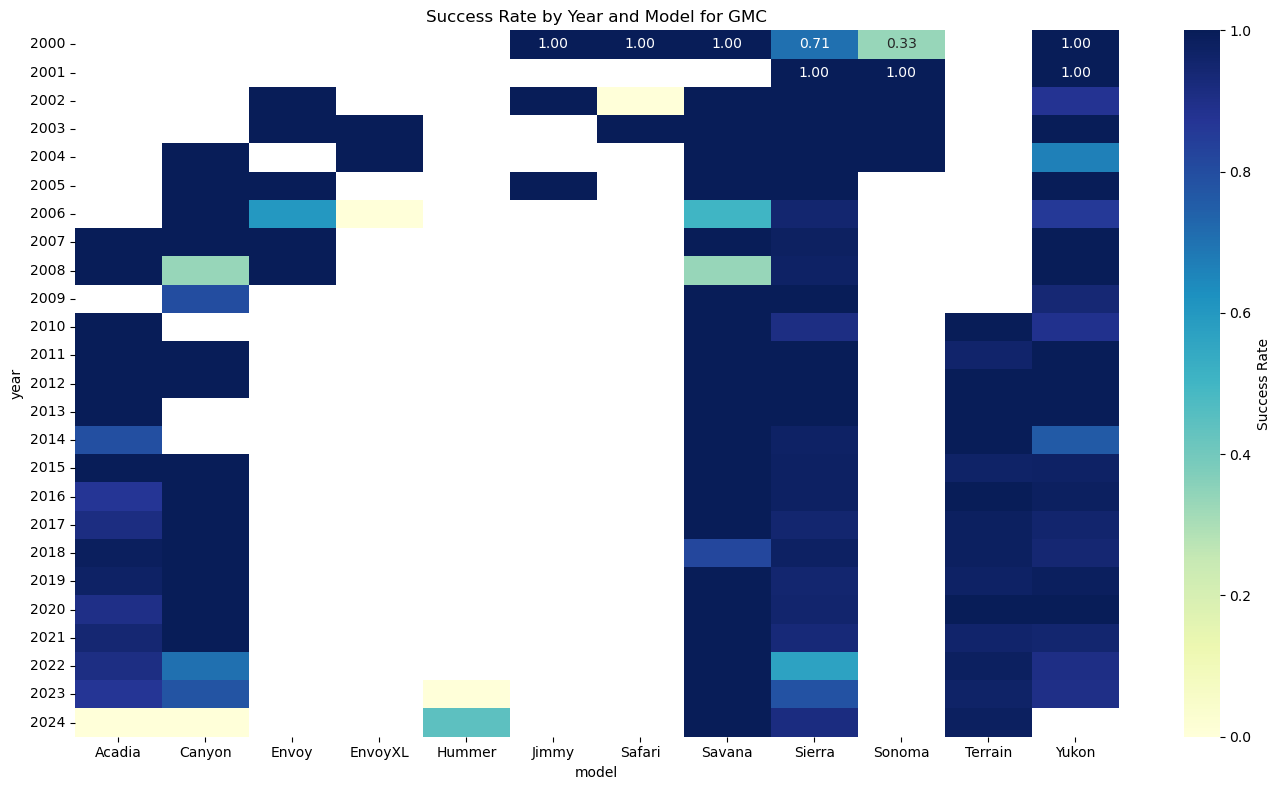

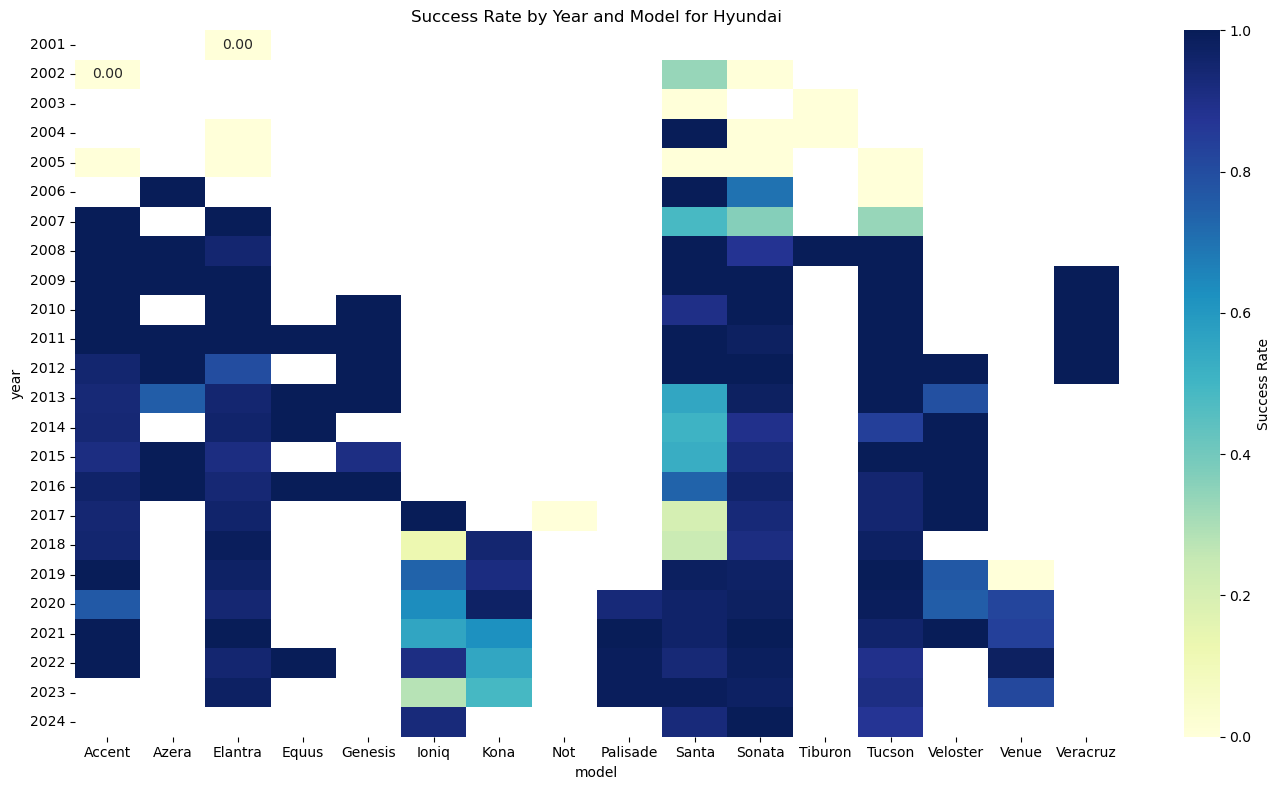

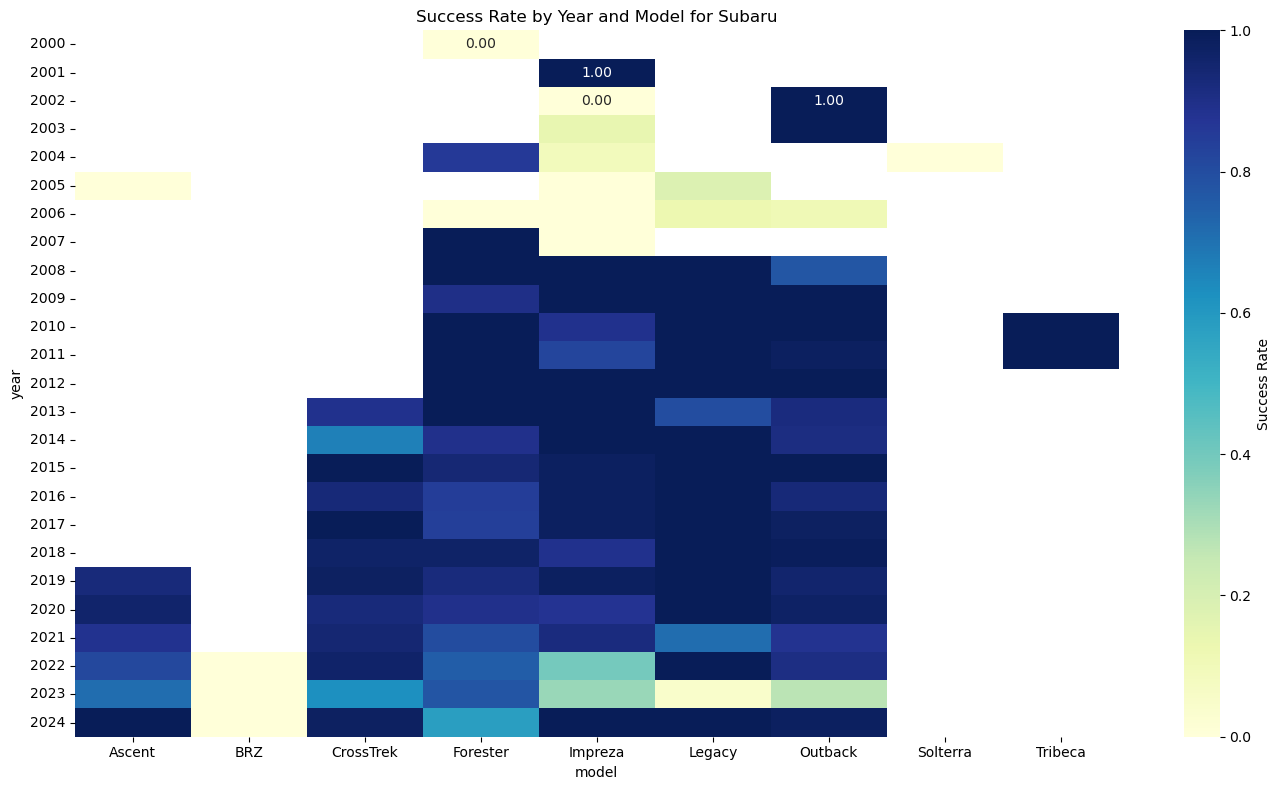

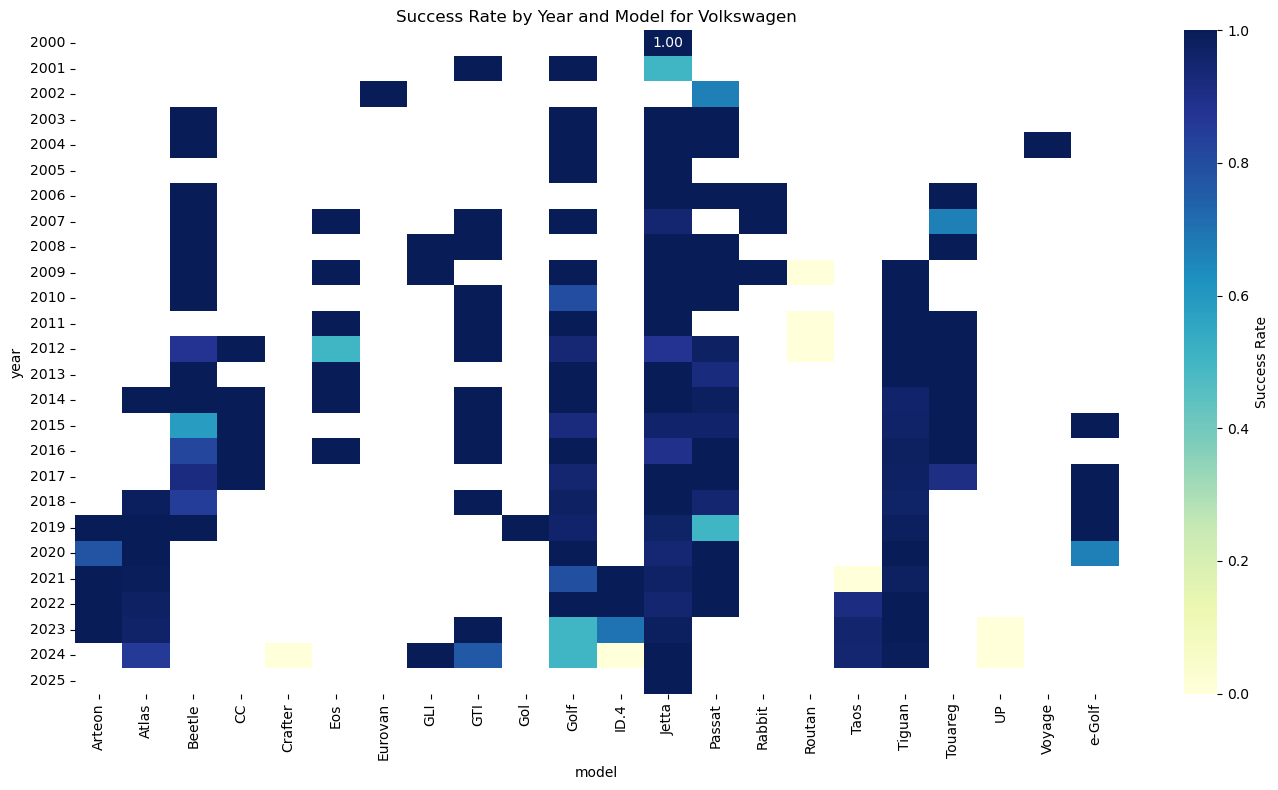

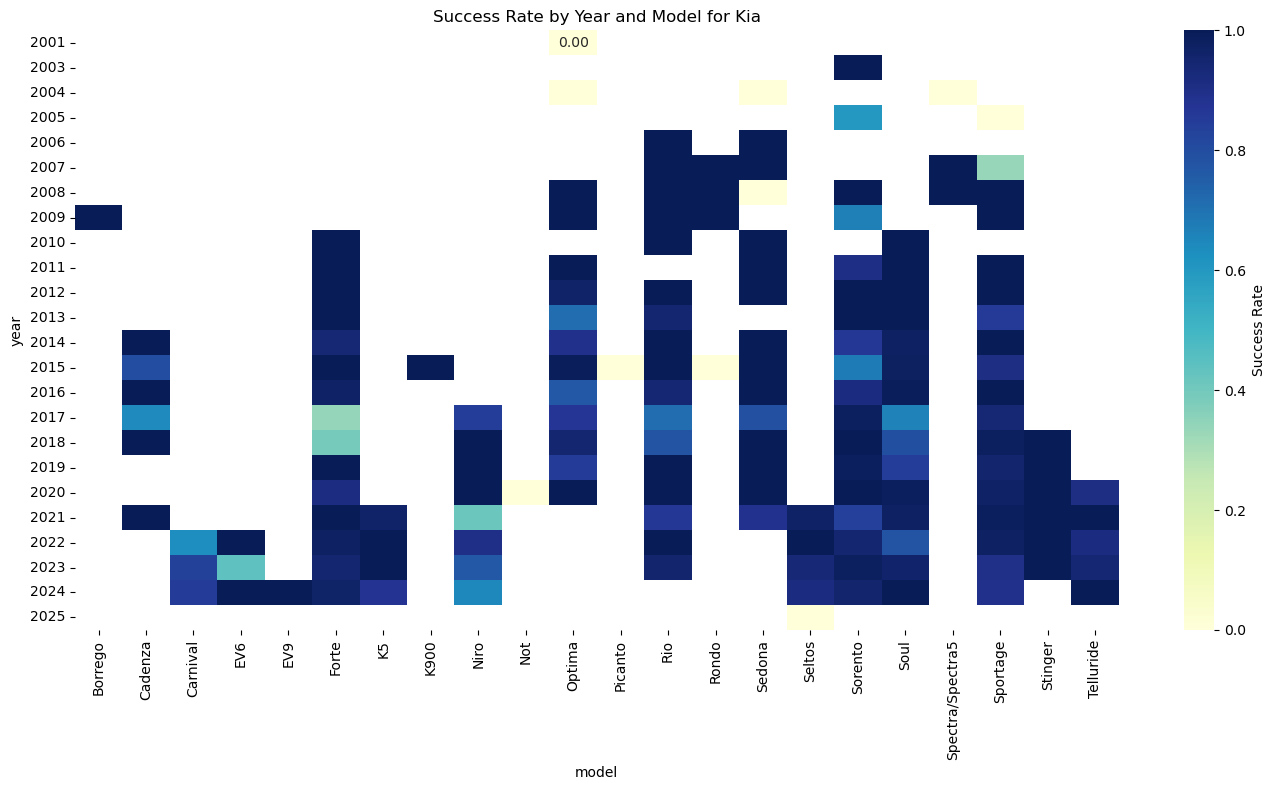

In [87]:
top_twelve_makes = ['Toyota', 'Ford', 'Chevrolet', 'Nissan', 'Honda', 'Dodge', 'Jeep', 'GMC', 'Hyundai', 'Subaru', 'Volkswagen', 'Kia']
for make in top_twelve_makes:
    make_df = diag_usage_df[diag_usage_df['make'] == make]
    create_contingency_table_results(make_df, 'model', 'year', f'Success Rate by Year and Model for {make}')

#### Analysis of vehicle systems 
The vehicle system represents the physical ECU (Electronic Control Unit) of the vehicle. It is the end point of communications. 
Look at distribution of vehicle systems. Determine connection success rate for individual systems. Look at veh_desc / system and vin / system combinations

In [88]:
systems = diag_usage_df['system'].unique()
print(f"Number of unique systems: {len(systems)}")

Number of unique systems: 866


In [89]:
#Determine the percentage of each system category
system_counts_df = diag_usage_df['system_category']
total_records = system_counts_df.shape[0]
system_counts = system_counts_df.value_counts()
system_counts_percent = system_counts / total_records * 100
system_counts_percent

system_category
Enhanced Powertrain            95.492017
Braking System                  1.378179
Airbag Control System           1.042259
Transmission Control System     0.409156
Body Control System             0.272367
Crash Safety System             0.239683
Occupant Sensing System         0.200947
TPMS                            0.176131
ADAS                            0.136789
other                           0.122263
Power Steering System           0.074447
HVAC Control System             0.068394
Infotainment System             0.056895
Drive Motor Control System      0.054473
Fuel Pump                       0.044789
Radio Control System            0.041763
Chassis Control System          0.032684
Park Assist                     0.029658
General Electronics System      0.029053
Theft Deterrent                 0.026026
Gateway                         0.023000
Battery Management System       0.019974
Head Lamp Control System        0.013316
Telematics                      0.010895


In [90]:
#Determine the percentage of each system category excluding the enhanced powertrain systems
system_counts_df = diag_usage_df[diag_usage_df['system_category'] != 'Enhanced Powertrain']['system_category']
total_records = system_counts_df.shape[0]
system_counts = system_counts_df.value_counts()
system_counts_percent = system_counts / total_records * 100
system_counts_percent
#total_records

system_category
Braking System                 30.571966
Airbag Control System          23.120301
Transmission Control System     9.076262
Body Control System             6.041890
Crash Safety System             5.316864
Occupant Sensing System         4.457573
TPMS                            3.907089
ADAS                            3.034372
other                           2.712137
Power Steering System           1.651450
HVAC Control System             1.517186
Infotainment System             1.262084
Drive Motor Control System      1.208378
Fuel Pump                       0.993555
Radio Control System            0.926423
Chassis Control System          0.725027
Park Assist                     0.657895
General Electronics System      0.644468
Theft Deterrent                 0.577336
Gateway                         0.510204
Battery Management System       0.443072
Head Lamp Control System        0.295381
Telematics                      0.241676
Accessory Power System          0.053706


In [91]:
makes_dict = {'top_10_makes': ['Toyota', 'Ford', 'Chevrolet', 'Nissan', 'Honda', 'Dodge', 'Jeep', 'GMC', 'Hyundai', 'Kia'],
              'asian_makes': ['Acura', 'Genesis', 'Honda', 'Hyundai', 'Isuzu', 'Kia', 'Lexus', 'Mazda', 'Mitsubishi', 'Nissan', 'Scion', 'Subaru', 'Toyota'],
              'european_makes': ['Alfa-Romeo', 'Aston-Martin', 'Audi', 'Bentley', 'BMW', 'Fiat', 'Infiniti', 'Jaguar', 'Land-Rover', 'Mercedes-Benz', 'MINI', 'Porsche', 'Saab', 'Seat', 'SMART', 'Volkswagen', 'Volvo'],
              'domestic_makes': ['Ford', 'Chevrolet', 'Dodge', 'GMC', 'Chrysler', 'Buick', 'Cadillac', 'Lincoln', 'Hummer', 'Jeep', 'Oldsmobile', 'Plymouth', 'Pontiac', 'Saturn' , 'Mercury'],
              'specialty_makes': ['Ferrari', 'Lamborghini', 'Maserati', 'McLaren']}

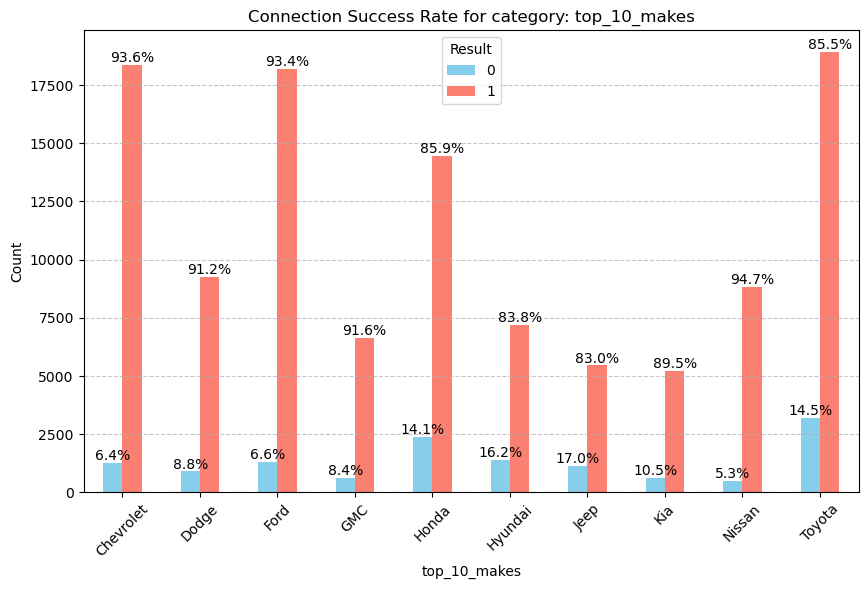

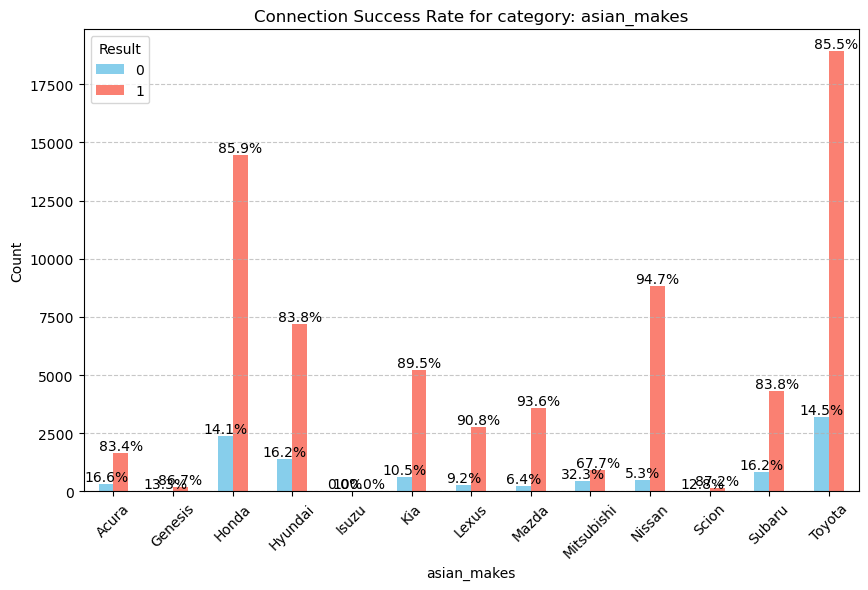

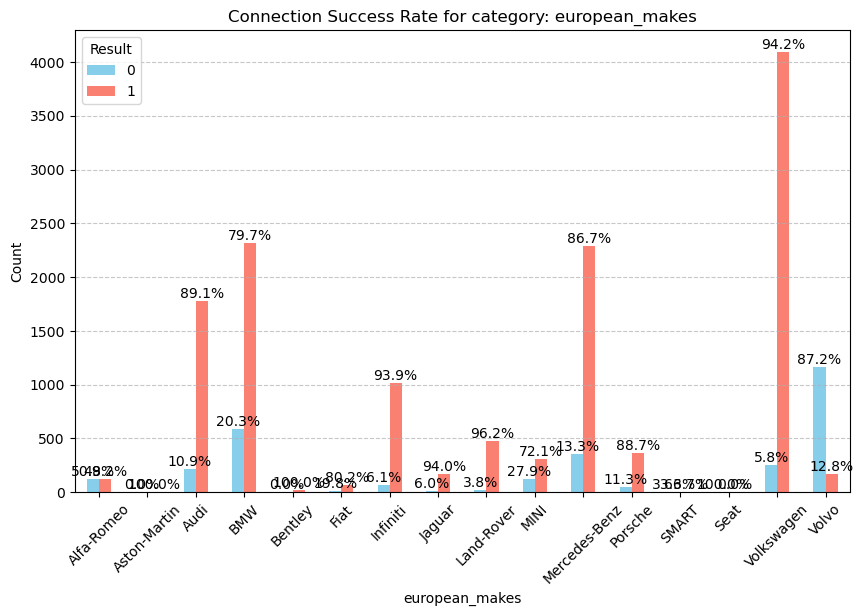

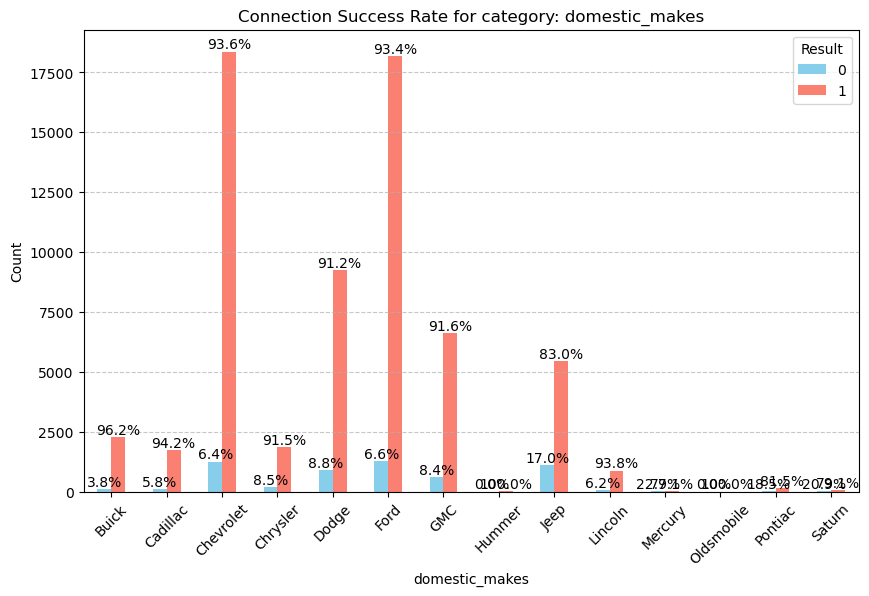

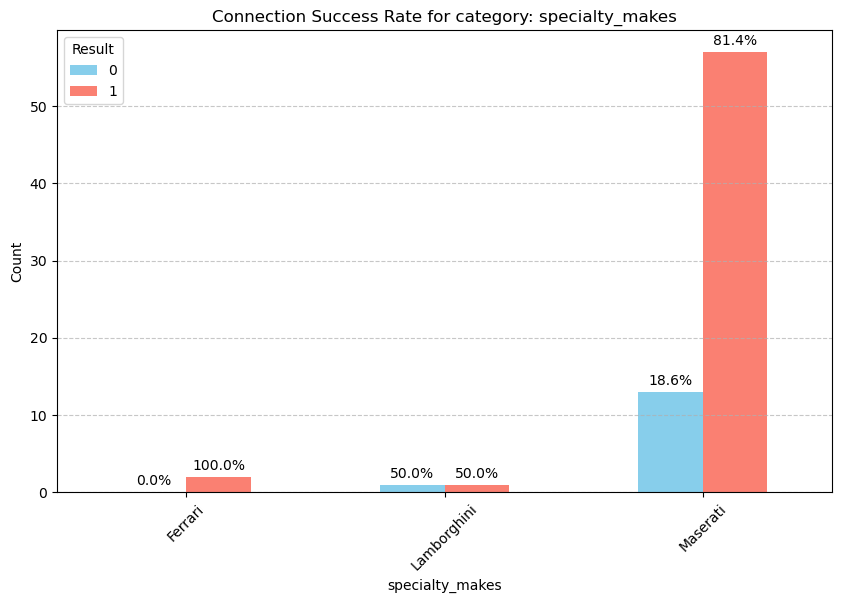

In [92]:
#plot the success rate by make category
for make_category, makes in makes_dict.items():
    makes_df = diag_usage_df[diag_usage_df['make'].isin(makes)]
    makes_df = pd.crosstab(makes_df['make'], makes_df['result'])
    percentages = makes_df.div(makes_df.sum(axis=1), axis=0) * 100
    ax = makes_df.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'salmon'])
    plt.title(f'Connection Success Rate for category: {make_category}')
    plt.xlabel(make_category)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title='Result')

    # Annotate percentages on the bars
    for bar_group, percentage_group in zip(ax.containers, percentages.T.iterrows()):
        for bar, percentage in zip(bar_group, percentage_group[1]):
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # X-coordinate
                bar.get_height() + 0.5,  # Y-coordinate
                f'{percentage:.1f}%',  # Percentage text
                ha='center', va='bottom', fontsize=10  # Align text
            )

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [93]:
#plot the success rate by make category
for make_category, makes in makes_dict.items():
    diag_usage_df.loc[diag_usage_df['make'].isin(makes), 'make_category'] = make_category
diag_usage_df['make_category'].value_counts()


make_category
asian_makes        78446
domestic_makes     70514
european_makes     16184
specialty_makes       74
Name: count, dtype: int64

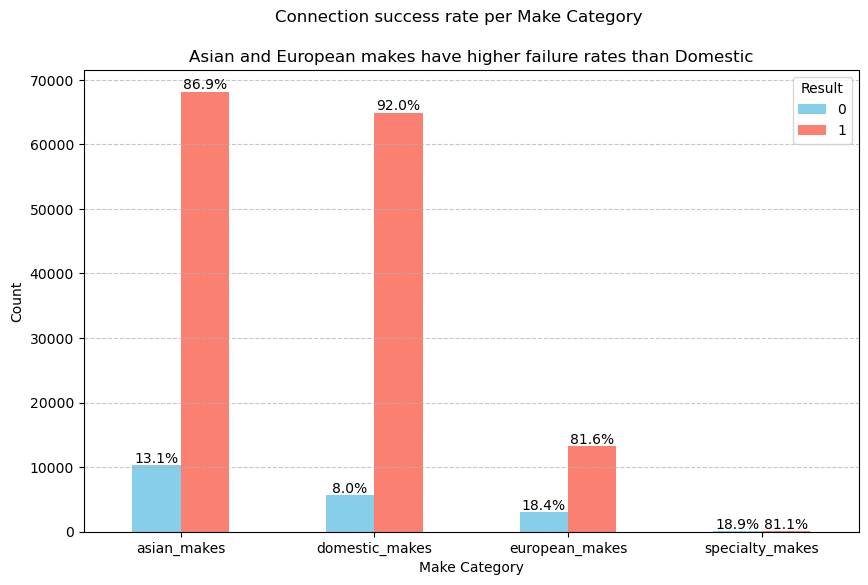

In [94]:

makes_df = pd.crosstab(diag_usage_df['make_category'], diag_usage_df['result'])
percentages = makes_df.div(makes_df.sum(axis=1), axis=0) * 100
ax = makes_df.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'salmon'])
plt.suptitle(f'Connection success rate per Make Category')
plt.title(f'Asian and European makes have higher failure rates than Domestic')
plt.xlabel('Make Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Result')

# Annotate percentages on the bars
for bar_group, percentage_group in zip(ax.containers, percentages.T.iterrows()):
    for bar, percentage in zip(bar_group, percentage_group[1]):
        ax.text(
                bar.get_x() + bar.get_width() / 2,  # X-coordinate
                bar.get_height() + 0.5,  # Y-coordinate
                f'{percentage:.1f}%',  # Percentage text
                ha='center', va='bottom', fontsize=10  # Align text
        )

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Analysis of scanning success rates for unique vehicle and system combinations.
The success rate for each unique combination of Year, Make, Model and System will be examined. This will be repeated for each unique combination of vin and system. It is expected that there will be many more vin / system combinations than year, make, model / system combinations. The vin contains more detailed information about each vehicle variant such as engine type, engine size, body type, etc. 
#### Note: The vehicle_desc is the same as concatenating Year, Make, Model features

In [95]:
#The number of failed and successful connections will be modified for lower number of scans
def compute_confidence_interval(row, alpha=0.05):
    ci_low, ci_upp = sm.stats.proportion_confint(
        count=row['num_success'], 
        nobs=row['total_scans'], 
        alpha=alpha, 
        method='wilson'
    )
    return pd.Series({'ci_low': ci_low, 'ci_upp': ci_upp})

In [118]:
veh_system_df = diag_usage_df.groupby(['year', 'make', 'model', 'system_category']).apply(
    lambda group: pd.Series({
        'num_success': group['result'].sum(),                # Total successful scans
        'total_scans': group['result'].count(),                    # Total scans
        'num_vins': group['vin'].nunique(),                  # How many vins make up this group
        'num_successful_shops': group.loc[group['result'] == 1, 'siteId'].nunique(),
        'num_failed_shops': group.loc[group['result'] == 0, 'siteId'].nunique()
    })
).reset_index().sort_values(by='total_scans', ascending=False)

veh_system_df['success_rate'] = veh_system_df['num_success'] / veh_system_df['total_scans'] * 100
veh_system_df['failure_rate'] = 100 - veh_system_df['success_rate']

ci_values = veh_system_df.apply(compute_confidence_interval, axis=1)
veh_system_df = pd.concat([veh_system_df, ci_values], axis=1)
veh_system_df.head()

,year,make,model,system_category,num_success,total_scans,num_vins,num_successful_shops,num_failed_shops,success_rate,failure_rate,ci_low,ci_upp
7041,2022,Chevrolet,Silverado,Enhanced Powertrain,399,710,249,159,75,56.197183,43.802817,0.525241,0.598036
5537,2019,Dodge,Ram,Enhanced Powertrain,574,638,198,195,25,89.968652,10.031348,0.873930,0.920658
8192,2024,Chevrolet,Silverado,Enhanced Powertrain,614,633,299,201,10,96.998420,3.001580,0.953597,0.980701
7084,2022,Dodge,Ram,Enhanced Powertrain,497,545,195,178,24,91.192661,8.807339,0.885159,0.932928
4601,2017,Honda,Civic,Enhanced Powertrain,471,536,141,164,26,87.873134,12.126866,0.848368,0.903705


In [117]:
veh_system_df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
year,8573.0,2015.23,6.33,2000.00,2011.00,2016.00,2021.00,2025.00
num_success,8573.0,17.07,44.48,0.00,1.00,2.00,11.00,614.00
total_scans,8573.0,19.27,49.75,1.00,1.00,3.00,13.00,710.00
num_vins,8573.0,7.80,17.13,1.00,1.00,2.00,6.00,299.00
num_successful_shops,8573.0,8.53,19.18,0.00,1.00,1.00,6.00,204.00
num_failed_shops,8573.0,0.91,2.70,0.00,0.00,0.00,1.00,75.00
success_rate,8573.0,79.31,36.39,0.00,80.00,100.00,100.00,100.00
failure_rate,8573.0,20.69,36.39,0.00,0.00,0.00,20.00,100.00
ci_low,8573.0,0.41,0.30,0.00,0.21,0.34,0.68,0.98
ci_upp,8573.0,0.93,0.14,0.03,0.93,1.00,1.00,1.00


In [98]:
threshold = veh_system_df['success_rate'].quantile(0.25)
intermittent_vehicles = veh_system_df[(veh_system_df['success_rate'] > 0) & (veh_system_df['success_rate'] < threshold)]

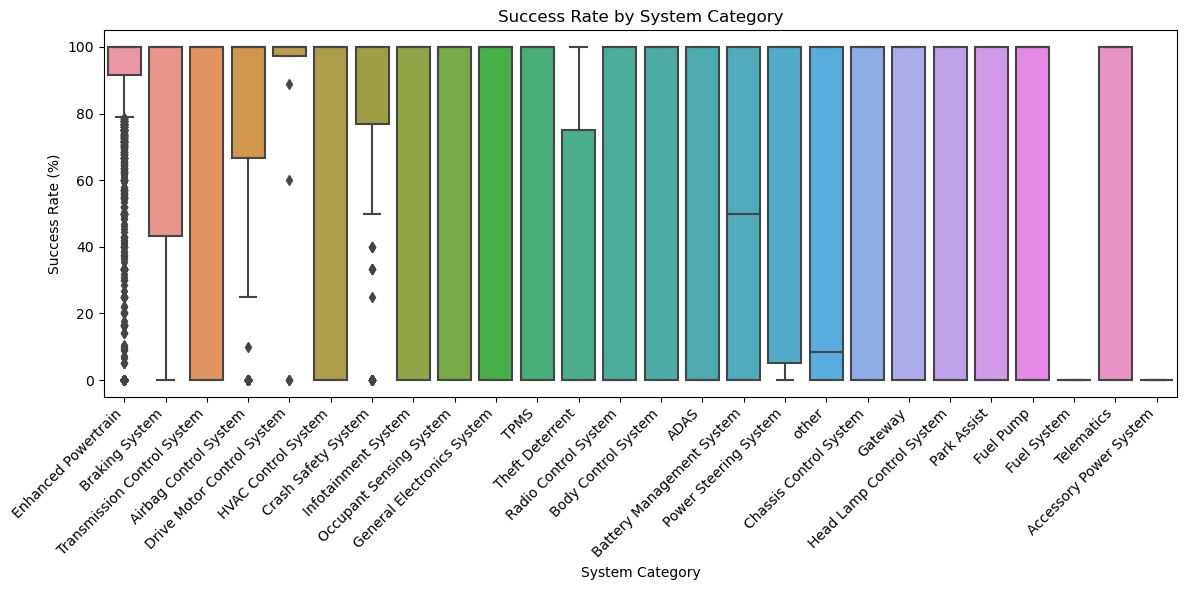

In [116]:
#create boxplot of success rate by system category for veh_system_df
plt.figure(figsize=(12, 6))
sns.boxplot(data=veh_system_df, x='system_category', y='success_rate')
plt.title('Success Rate by System Category')
plt.xlabel('System Category')
plt.ylabel('Success Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

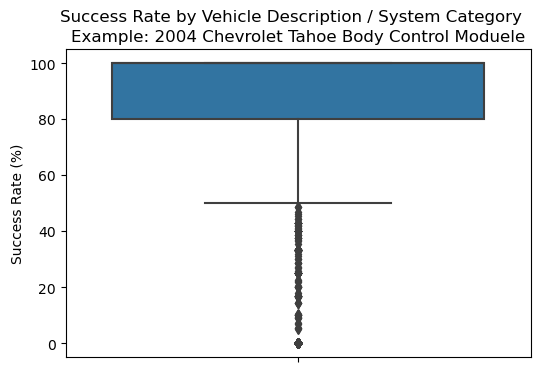

In [115]:
#create boxplot of success_rate for veh_system_df
plt.figure(figsize=(6, 4))
sns.boxplot(data=veh_system_df, y='success_rate', orient='v')
plt.suptitle('Success Rate by Vehicle Description / System Category')
plt.title('Example: 2004 Chevrolet Tahoe Body Control Moduele')
plt.ylabel('Success Rate (%)')
plt.show()

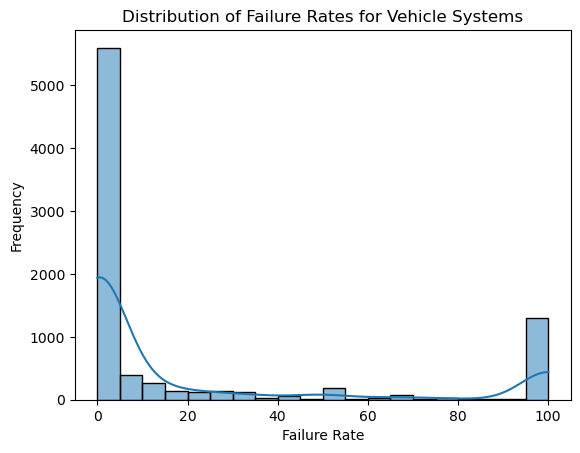

In [101]:
#create distribution of failure rate
sns.histplot(veh_system_df['failure_rate'], kde=True, bins=20)
#add title and labels
plt.xlabel('Failure Rate')
plt.ylabel('Frequency')
plt.title('Distribution of Failure Rates for Vehicle Systems')
plt.show()


In [102]:
vin_system_df = diag_usage_df.groupby(['vin', 'system_category']).apply(
    lambda group: pd.Series({
        'num_success': group['result'].sum(),                # Total successful scans
        'total_scans': group['result'].count(),                    # Total scans
        'num_veh': group['veh_desc'].nunique(),                  # How many vehicle descriptions
        'num_successful_shops': group.loc[group['result'] == 1, 'siteId'].nunique(),
        'num_failed_shops': group.loc[group['result'] == 0, 'siteId'].nunique()
    })
).reset_index().sort_values(by='total_scans', ascending=False)

vin_system_df['success_rate'] = vin_system_df['num_success'] / vin_system_df['total_scans'] * 100
vin_system_df['failure_rate'] = 100 - vin_system_df['success_rate']

ci_values = vin_system_df.apply(compute_confidence_interval, axis=1)
vin_system_df = pd.concat([vin_system_df, ci_values], axis=1)
vin_system_df.head()

,vin,system_category,num_success,total_scans,num_veh,num_successful_shops,num_failed_shops,success_rate,failure_rate,ci_low,ci_upp
12381,1G8AJ52F84Z,Enhanced Powertrain,41,41,1,1,0,100.000000,0.000000,0.914332,1.000000
10164,1FTPW12536F,Enhanced Powertrain,41,41,1,1,0,100.000000,0.000000,0.914332,1.000000
38487,4T1BF1FK6HU,Enhanced Powertrain,30,40,1,14,1,75.000000,25.000000,0.598060,0.858129
21388,1YVHP82A995,Enhanced Powertrain,33,38,1,1,1,86.842105,13.157895,0.726731,0.942461
53285,JTDKAMFUXN3,Enhanced Powertrain,25,36,1,4,1,69.444444,30.555556,0.531437,0.819955


In [103]:
vin_system_df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
num_success,65358.0,2.24,2.07,0.0,1.00,2.00,3.00,41.00
total_scans,65358.0,2.53,2.37,1.0,1.00,2.00,3.00,41.00
num_veh,65358.0,1.02,0.18,1.0,1.00,1.00,1.00,8.00
num_successful_shops,65358.0,1.30,0.89,0.0,1.00,1.00,1.00,15.00
num_failed_shops,65358.0,0.12,0.34,0.0,0.00,0.00,0.00,5.00
success_rate,65358.0,92.38,23.94,0.0,100.00,100.00,100.00,100.00
failure_rate,65358.0,7.62,23.94,0.0,0.00,0.00,0.00,100.00
ci_low,65358.0,0.31,0.15,0.0,0.21,0.34,0.44,0.91
ci_upp,65358.0,0.97,0.09,0.1,1.00,1.00,1.00,1.00


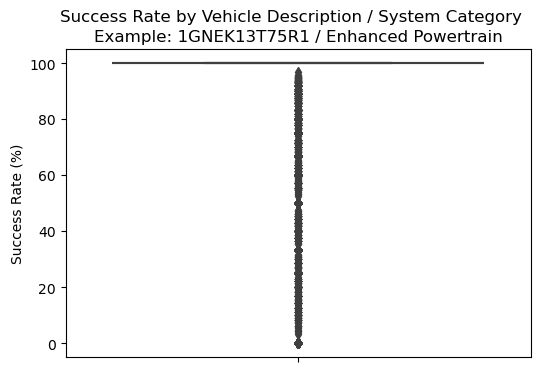

In [104]:
#create boxplot of success_rate for vin_system_df
plt.figure(figsize=(6, 4))
sns.boxplot(data=vin_system_df, y='success_rate', orient='v')
plt.suptitle('Success Rate by Vehicle Description / System Category')
plt.title('Success Rate by VIN and System Category')
plt.title('Example: 1GNEK13T75R1 / Enhanced Powertrain')
plt.ylabel('Success Rate (%)')
plt.show()

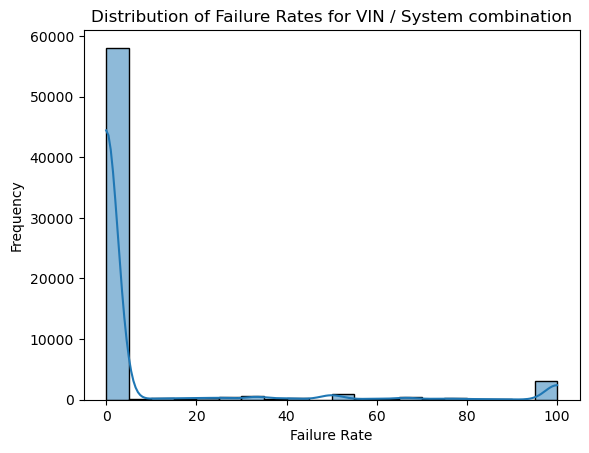

In [105]:
#create distribution of failure rate
sns.histplot(vin_system_df['failure_rate'], kde=True, bins=20)
#add title and labels
plt.xlabel('Failure Rate')
plt.ylabel('Frequency')
plt.title('Distribution of Failure Rates for VIN / System combination')
plt.show()

In [106]:
#find entries that account for passed in percentage of of scans. Assumes passed in dataframe has a 'total' column
def get_entries_for_percentage(df, threshold):
    total = df['total'].sum()
    #sort the dataframe
    df = df.sort_values(by='total', ascending=False)
    #get the cumulative total for each unique vehicle / system combination
    df['cumulative_total'] = df['total'].cumsum()
    #get the cumulative percentage for each unique vehicle / system combination
    df['cumulative_pct'] = df['cumulative_total'] / total * 100
    idx = np.argmax(df['cumulative_pct'] >= threshold)
    return df.iloc[:idx+1]

In [107]:
vin_system_df.describe().round(2).T


,count,mean,std,min,25%,50%,75%,max
num_success,65358.0,2.24,2.07,0.0,1.00,2.00,3.00,41.00
total_scans,65358.0,2.53,2.37,1.0,1.00,2.00,3.00,41.00
num_veh,65358.0,1.02,0.18,1.0,1.00,1.00,1.00,8.00
num_successful_shops,65358.0,1.30,0.89,0.0,1.00,1.00,1.00,15.00
num_failed_shops,65358.0,0.12,0.34,0.0,0.00,0.00,0.00,5.00
success_rate,65358.0,92.38,23.94,0.0,100.00,100.00,100.00,100.00
failure_rate,65358.0,7.62,23.94,0.0,0.00,0.00,0.00,100.00
ci_low,65358.0,0.31,0.15,0.0,0.21,0.34,0.44,0.91
ci_upp,65358.0,0.97,0.09,0.1,1.00,1.00,1.00,1.00


## Investigate scan success rates between different connection methods for different makes
#### The diagnostics tool supports two connection methods, Manual Scan and Quick Scan. For Quick Scan, the tool attempts to learn the vehicle attributes (year, make, model, engine, transmission, etc) automatically by interagating the vehicle. For Manual Scan, the user enters these values manually from drop down menus. It has been assumed that manually selecting the vehicle options will give a higher connection success rate especially for makes such as BMW.

In [108]:
#Create dataframe that shows number of scan by each scanning type
#make_df = diag_usage_df.groupby(['make', 'scan_method'])['result'].sum().unstack().reset_index()
#make_df.sample(1)

In [109]:
#Create dataframe that shows number of scan by each scanning type
make_scan_df = diag_usage_df.groupby(['make', 'scan_method']).apply(
    lambda group: pd.Series({
    'successes': group['result'].sum(),                # Total successful scans
    'failures': group.loc[group['result'] == 0, 'result'].count(),                # Total successful scans
    'total': group['result'].count(),                    # Total scans
    'successful_shops': group.loc[group['result'] == 1, 'siteId'].nunique(),
    'failed_shops': group.loc[group['result'] == 0, 'siteId'].nunique()})).reset_index()
make_scan_df.sample(5)

,make,scan_method,successes,failures,total,successful_shops,failed_shops
83,Volkswagen,manual scan,987,68,1055,234,16
12,Buick,quick_scan,1738,62,1800,365,34
67,Oldsmobile,quick_scan,2,0,2,2,0
41,Jaguar,quick_scan,134,7,141,67,5
42,Jeep,manual scan,1466,275,1741,296,83


In [110]:
#Get the success rate and failure rate for each make and scan method
make_scan_df['success_rate'] = make_scan_df['successes'] / make_scan_df['total'] * 100
make_scan_df['failure_rate'] = make_scan_df['failures'] / make_scan_df['total'] * 100
make_scan_df.sample(5)

,make,scan_method,successes,failures,total,successful_shops,failed_shops,success_rate,failure_rate
63,Mitsubishi,manual scan,251,125,376,82,32,66.755319,33.244681
3,Alfa-Romeo,quick_scan,92,105,197,52,43,46.700508,53.299492
9,Bentley,manual scan,3,0,3,1,0,100.000000,0.000000
56,Maserati,quick_scan,42,10,52,16,4,80.769231,19.230769
51,Lincoln,manual scan,185,20,205,90,7,90.243902,9.756098


In [111]:
#pivot on the make column
make_scan_pivot_df = make_scan_df.pivot(index='make', columns='scan_method', values=['success_rate', 'failure_rate', 'total'])

#Determine the differences between quick_scan and manual scan success and failure rates
make_scan_pivot_df['success_rate_diff'] = make_scan_pivot_df['success_rate']['quick_scan'] - make_scan_pivot_df['success_rate']['manual scan']

#success and failure rate differences are the same value with opposite sign we can just use the success rate difference
#make_scan_pivot_df['failure_rate_diff'] = make_scan_pivot_df['failure_rate']['quick_scan'] - make_scan_pivot_df['failure_rate']['manual scan']

make_scan_pivot_df = make_scan_pivot_df.reset_index()

#sort by absolute value of success rate difference
make_scan_pivot_df = make_scan_pivot_df.sort_values(by='success_rate_diff', ascending=False)

#Only keep samples for makes with at least 50 total scans
make_scan_pivot_df['total_scans'] = make_scan_pivot_df['total']['manual scan'] + make_scan_pivot_df['total']['quick_scan']
mask = make_scan_pivot_df['total_scans'].fillna(0) > 50
make_scan_pivot_df = make_scan_pivot_df[mask]

#used to highlight makes with lower scans
make_scan_pivot_df['inv_total_scans'] = make_scan_pivot_df['total_scans'].max() - make_scan_pivot_df['total_scans'] + 1
make_scan_pivot_df['total_scans_adj'] = (make_scan_pivot_df['total_scans'] * 10) + 5

make_scan_pivot_df.sample(10)


make success_rate            failure_rate             \
scan_method              manual scan quick_scan  manual scan quick_scan   
14                  GMC    90.581854  92.006149     9.418146   7.993851   
25           Land-Rover    97.887324  95.530726     2.112676   4.469274   
42               Subaru    82.602922  84.339984    17.397078  15.660016   
19             Infiniti    97.744361  92.665037     2.255639   7.334963   
27              Lincoln    90.243902  94.868239     9.756098   5.131761   
39               Saturn    56.250000  84.285714    43.750000  15.714286   
4                   BMW    79.432624  79.932356    20.567376  20.067644   
34               Nissan    94.120228  94.863791     5.879772   5.136209   
26                Lexus    94.616420  89.531318     5.383580  10.468682   
0                 Acura    84.294235  83.039349    15.705765  16.960651   

                  total            success_rate_diff total_scans  \
scan_method manual scan quick_scan                                 
14               2028.0     5204.0          1.424295      7232.0   
25                142.0      358.0         -2.356598       500.0   
42               1506.0     3659.0          1.737062      5165.0   
19                266.0      818.0         -5.079324      1084.0   
27                205.0      721.0          4.624336       926.0   
39                 16.0       70.0         28.035714        86.0   
4                1128.0     1774.0          0.499732      2902.0   
34               2279.0     7048.0          0.743563      9327.0   
26                743.0     2283.0         -5.085101      3026.0   
0                 503.0     1474.0         -1.254886      1977.0   

            inv_total_scans total_scans_adj  
scan_method                                  
14                  14879.0         72325.0  
25                  21611.0          5005.0  
42                  16946.0         51655.0  
19                  21027.0         10845.0  
27                  21185.0          9265.0  
39                  22025.0           865.0  
4                   19209.0         29025.0  
34                  12784.0         93275.0  
26                  19085.0         30265.0  
0                   20134.0         19775.0

In [112]:
#makes_df.head()
#rename 1 column to success
fig = px.scatter(make_scan_pivot_df, x='make', y='success_rate_diff', color="make",
                hover_data={'make', 'total_scans'},
                size='total_scans_adj',
                size_max=50,
                color_continuous_scale='Viridis',
                title="Vehicle Make Success Rate Differences: Quick Scan vs. Manual Scan (Size of marker represents total scans)")
fig.show()

## Investigate scanning results based on OS
It is assumed that the operating system used to perform a scan will not affect the scanning rate. We will double check this to make sure. Note: iOS represents iPad and iPadOS represents iPhones 

In [113]:
# Look at application usage by OS
os_name_counts = diag_usage_df['OsName'].value_counts()
fig = px.pie(
    os_name_counts,
    values=os_name_counts.values,
    names=os_name_counts.index,
    title='Distribution of OS in Diag Usage Data'
)
fig.show()

In [114]:
#calculate success rate for each OS
os_success_rate = diag_usage_df.groupby('OsName')['result'].mean()
os_success_rate

OsName
Android    0.885848
Windows    0.887487
iOS        0.883213
iPadOS     0.884506
Name: result, dtype: float64

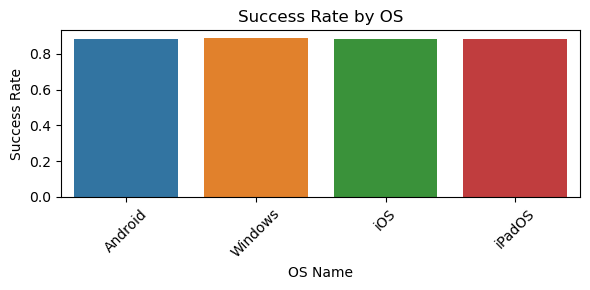

In [ ]:
# bar plot of success rate by OS
plt.figure(figsize=(6, 3))
sns.barplot(x=os_success_rate.index, y=os_success_rate.values)
plt.title('Success Rate by OS')
plt.xlabel('OS Name')
plt.ylabel('Success Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [144]:
df = diag_usage_df

Outlier veh_desc values:
                      veh_desc    n  failures  failure_rate  std_error  \
79    2001 Chevrolet Silverado   56        56      1.000000   0.042520   
157   2002 Chevrolet Silverado   33        33      1.000000   0.055391   
297           2003 Honda Civic   38        24      0.631579   0.051618   
392         2004 Dodge Cummins   33        33      1.000000   0.055391   
405      2004 Ford PowerStroke   47        36      0.765957   0.046413   
...                        ...  ...       ...           ...        ...   
4876        2024 Toyota Tacoma  137        67      0.489051   0.027185   
4884       2024 Volkswagen GTI   34        26      0.764706   0.054570   
4885      2024 Volkswagen Golf   32        16      0.500000   0.056249   
4887     2024 Volkswagen Jetta   87        87      1.000000   0.034114   
4889    2024 Volkswagen Tiguan   94        93      0.989362   0.032819   

        z_score  
79     2.688483  
157    2.063813  
297   -4.922814  
392    2.06381

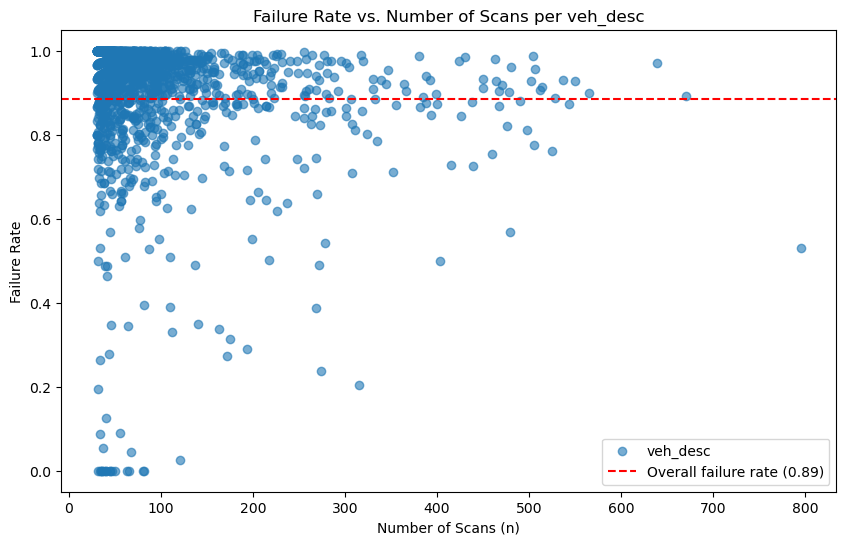

In [145]:
from statsmodels.stats.proportion import proportions_ztest

# Assume your dataframe is called df and has columns: result and veh_desc

# Group by veh_desc and compute total scans and failures
grouped = df.groupby('veh_desc')['result'].agg(['count', 'sum']).reset_index()
grouped.rename(columns={'count': 'n', 'sum': 'failures'}, inplace=True)
grouped['failure_rate'] = grouped['failures'] / grouped['n']

# Calculate overall failure rate
overall_rate = df['result'].mean()

# Calculate standard error and z-score for each veh_desc group
grouped['std_error'] = np.sqrt(overall_rate * (1 - overall_rate) / grouped['n'])
grouped['z_score'] = (grouped['failure_rate'] - overall_rate) / grouped['std_error']

# Optionally, filter out groups with very few scans to avoid unreliable estimates
min_scans = 30
grouped_filtered = grouped[grouped['n'] >= min_scans]

# Identify veh_desc values with extreme z-scores (e.g., z > 2 or z < -2)
outliers = grouped_filtered[(grouped_filtered['z_score'] > 2) | (grouped_filtered['z_score'] < -2)]
print("Outlier veh_desc values:")
print(outliers)

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(grouped_filtered['n'], grouped_filtered['failure_rate'], alpha=0.6, label='veh_desc')
plt.axhline(overall_rate, color='red', linestyle='--', label=f'Overall failure rate ({overall_rate:.2f})')
plt.xlabel('Number of Scans (n)')
plt.ylabel('Failure Rate')
plt.title('Failure Rate vs. Number of Scans per veh_desc')
plt.legend()
plt.show()
